# 0.0. IMPORTS

In [1]:
import inflection
import math
import random
import pickle
import requests
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from scipy                 import stats    as ss
from boruta                import BorutaPy
from tabulate              import tabulate
from matplotlib            import pyplot   as plt
from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore')

## 0.1. Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1) ):
        if verbose:
            print( '\nKfold Number: {}'.format( k ) ) 
            
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days= k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days= (k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date','sales'], axis = 1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date','sales'], axis = 1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
  
    return pd.DataFrame( {'Model Name': model_name,
                        'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype(str),
                        'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype(str) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype(str),
                        'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype(str) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype(str)}, index = [0])


def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame(
        {
            'Model Name': model_name,
            'MAE': mae,
            'MAPE': mape,
            'RMSE': rmse
        },
        index=[0])


def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]

    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))

    kcorr = k - ((k - 1)**2) / (n - 1)

    rcorr = r - ((r - 1)**2) / (n - 1)

    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))


def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; } </style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
# loading sales and store
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = "Store")

# 1.0. DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# change structure of cols name 
snakecase = lambda x: inflection.underscore( x )
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

In [7]:
# show colums with new format
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print('Number of Rows: {}'.format( df1.shape[0] ) )

print('Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan ( x ) else x )

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1 )

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1 )
                   
# promo2_since_week        
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1)

# promo2_since_year           
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1)

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jun', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0,inplace = True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [12]:
df1.sample(5).T

,502535,164858,796923,983613,82251
store,456,954,484,969,857
day_of_week,1,5,3,4,2
date,2014-04-07 00:00:00,2015-03-06 00:00:00,2013-07-17 00:00:00,2013-01-31 00:00:00,2015-05-19 00:00:00
sales,5069,6995,6931,0,8841
customers,861,878,644,0,958
open,1,1,1,0,1
promo,0,1,1,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,1,0,0
store_type,a,a,a,a,c


In [13]:
# check NA values
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes(include = ['int64','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [18]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = (['attributes','min','max','range','mean','median','std','skew','kurtosis'])

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


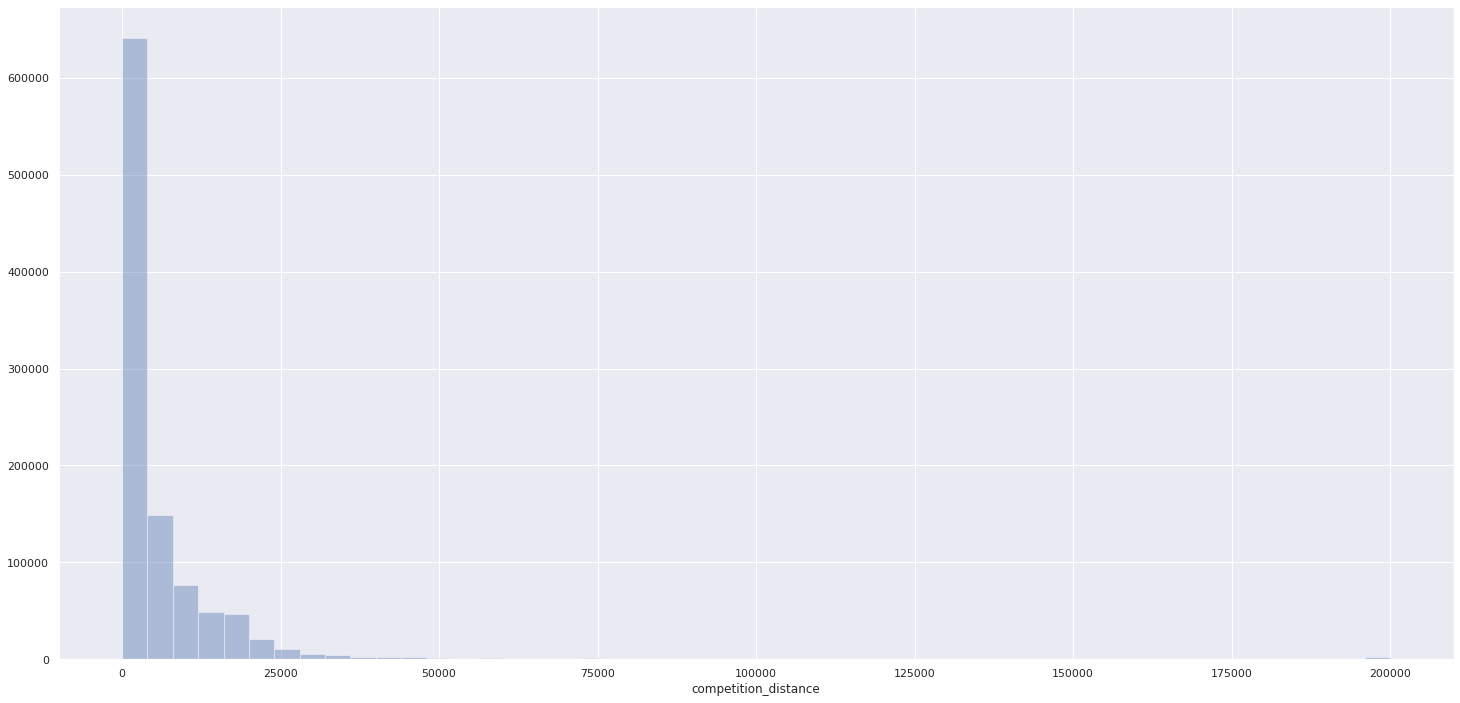

In [19]:
sns.distplot( df1['competition_distance'], kde=False );

### 1.7.2 Categorical Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         11
dtype: int64

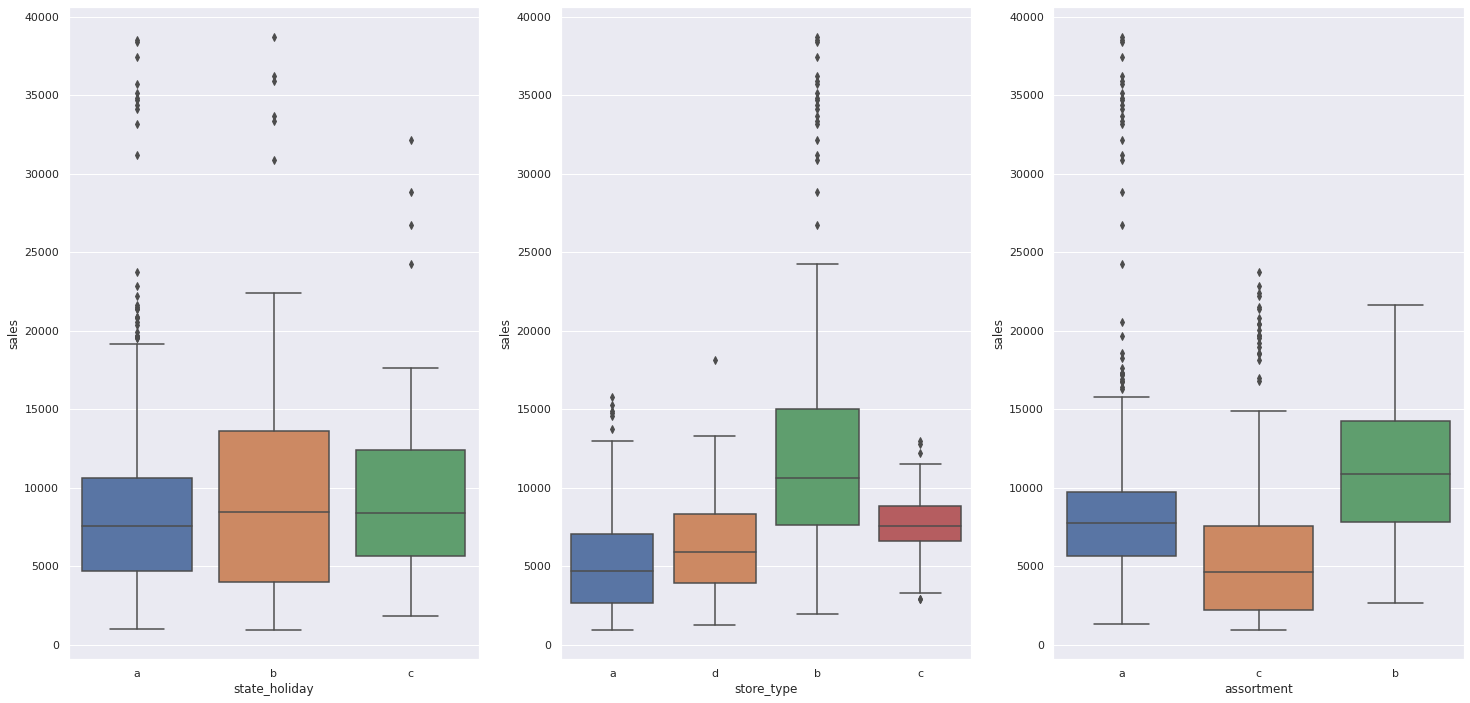

In [21]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3 , 1 )
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1 );

plt.subplot( 1, 3 , 2 )
sns.boxplot(x = 'store_type', y = 'sales', data = aux1 );

plt.subplot( 1, 3 , 3 )
sns.boxplot(x = 'assortment', y = 'sales', data = aux1 );

# 2.0. FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

## 2.1. Mindmap Hypothesis

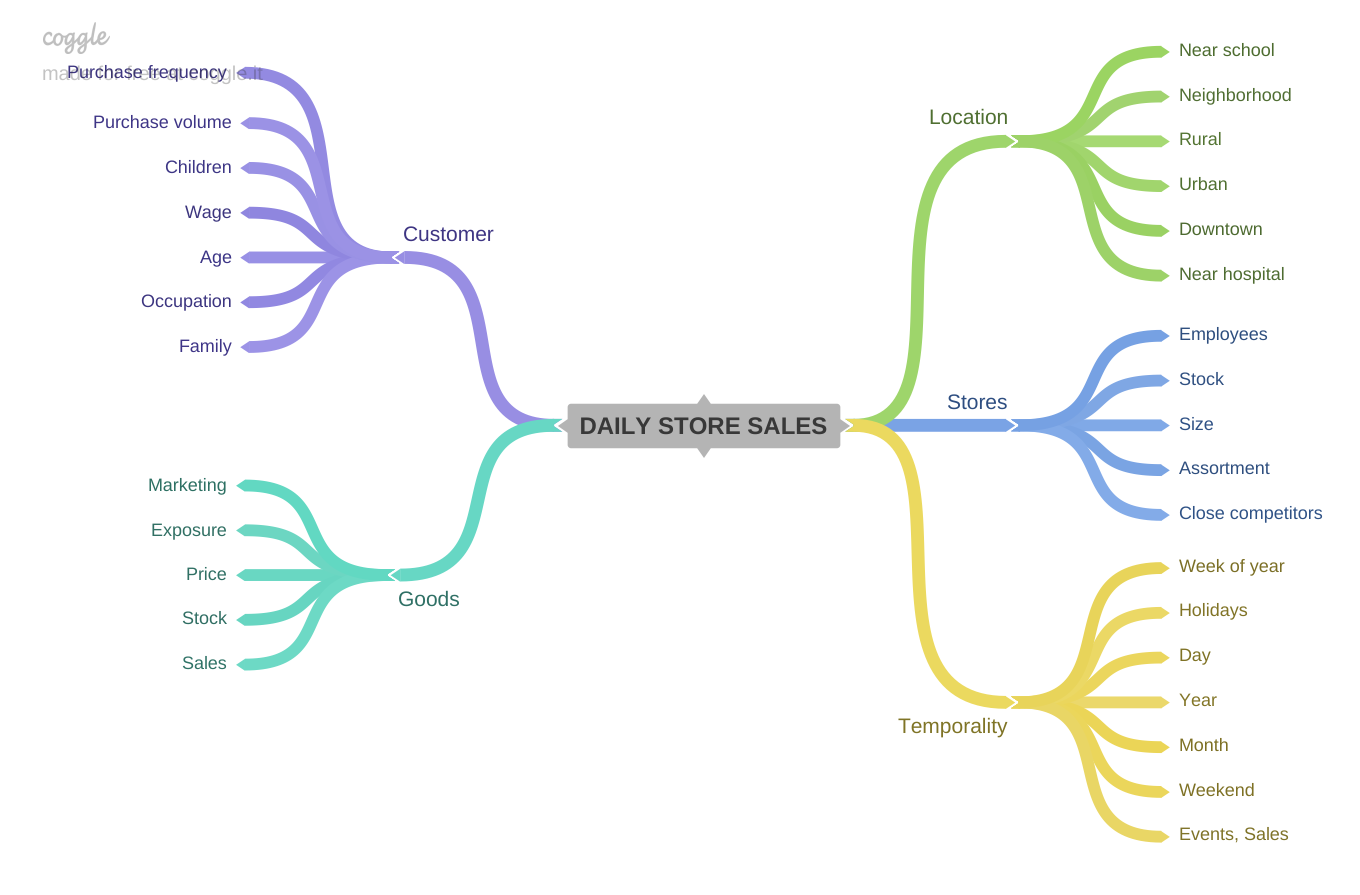

In [23]:
Image('img/MindMapHypothesis.png')

## 2.2. Hypotesis Creation

###  2.2.1. Store Hypothesis

**1.** Stores with more employees should sell more..

**2.** Stores with more inventory capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with larger assortments should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with longer-term competitors should sell more.

###  2.2.2. Product Hipothesis

**1.** Stores with more marketing investment should sell more.

**2.** Stores with more product exposure should sell more.

**3.** Stores with lower priced products should sell more.

**4.** Stores with more aggressive promotions (bigger discounts), should sell more.

**5.** Stores with promotions active for longer should sell more.

**6.** Stores with more promotion days should sell more.

**7.** Stores with more consecutive promotions should sell more.

###  2.2.3. Time Hypothesis

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 2.3. Final List of Hypotheses

**1.** Stores with larger assortments should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer-term competitors should sell more.

**4.** Stores with promotions active for longer should sell more.

**5.** Stores with more consecutive promotions should sell more.

**6.** Stores open during the Christmas holiday should sell more.

**7.** Stores should sell more over the years.

**8.** Stores should sell more in the second half of the year.

**9.** Stores should sell more after the 10th of each month.

**10.** Stores should sell less on weekends.

**11.** Stores should sell less during school holidays.


## 2.4 Feature Engineering

In [24]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(int64)

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'] , month = x['competition_open_since_month'], day = 1 ), axis = 1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/ 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. DATA CLEANING    

In [25]:
df3 = df2.copy()

## 3.1. Rows filtering

In [26]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns selection

In [27]:
cols_drop = ['customers','open', 'promo_interval','month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [28]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. EXPLORATORY DATA ANALYSIS

In [29]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

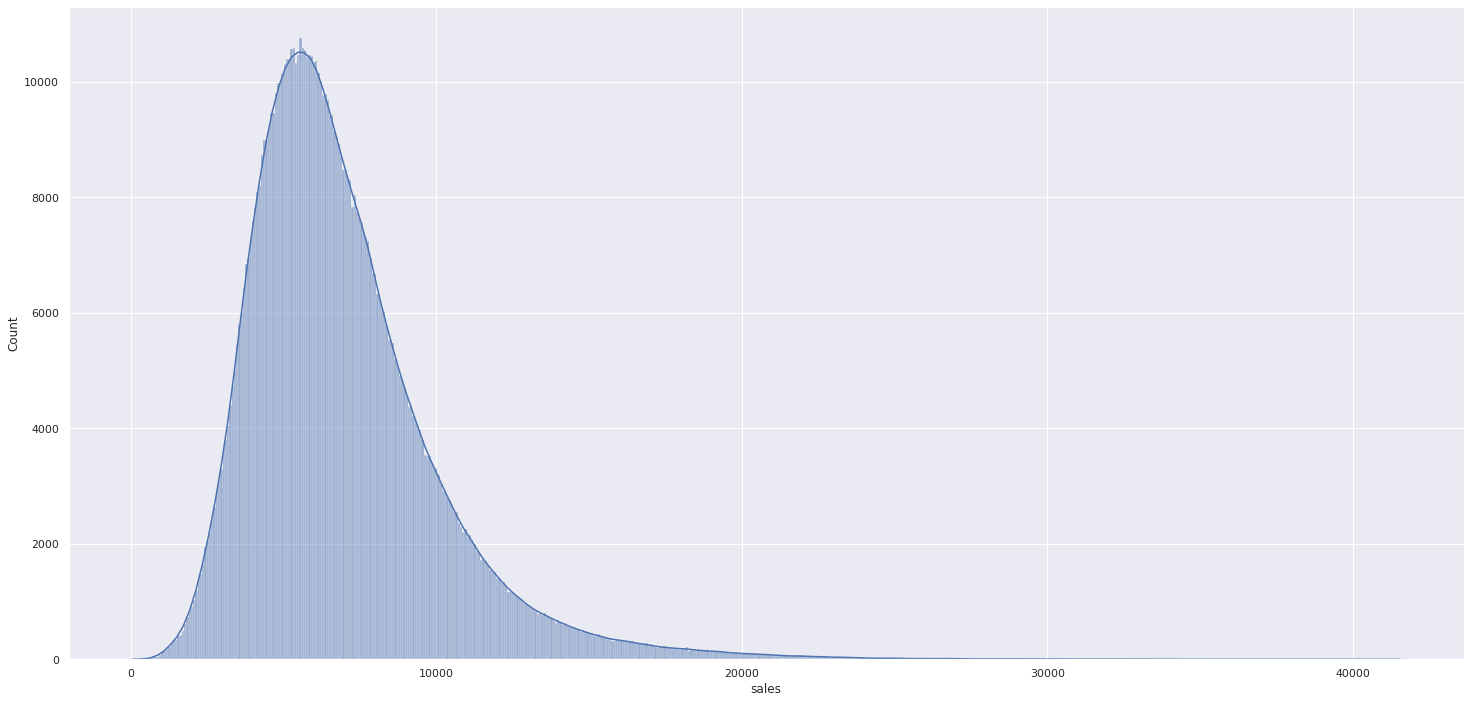

In [30]:
# plotando a distribuição da variação resposta
sns.histplot(df4['sales'], kde = True);

### 4.1.2. Numerical Variable

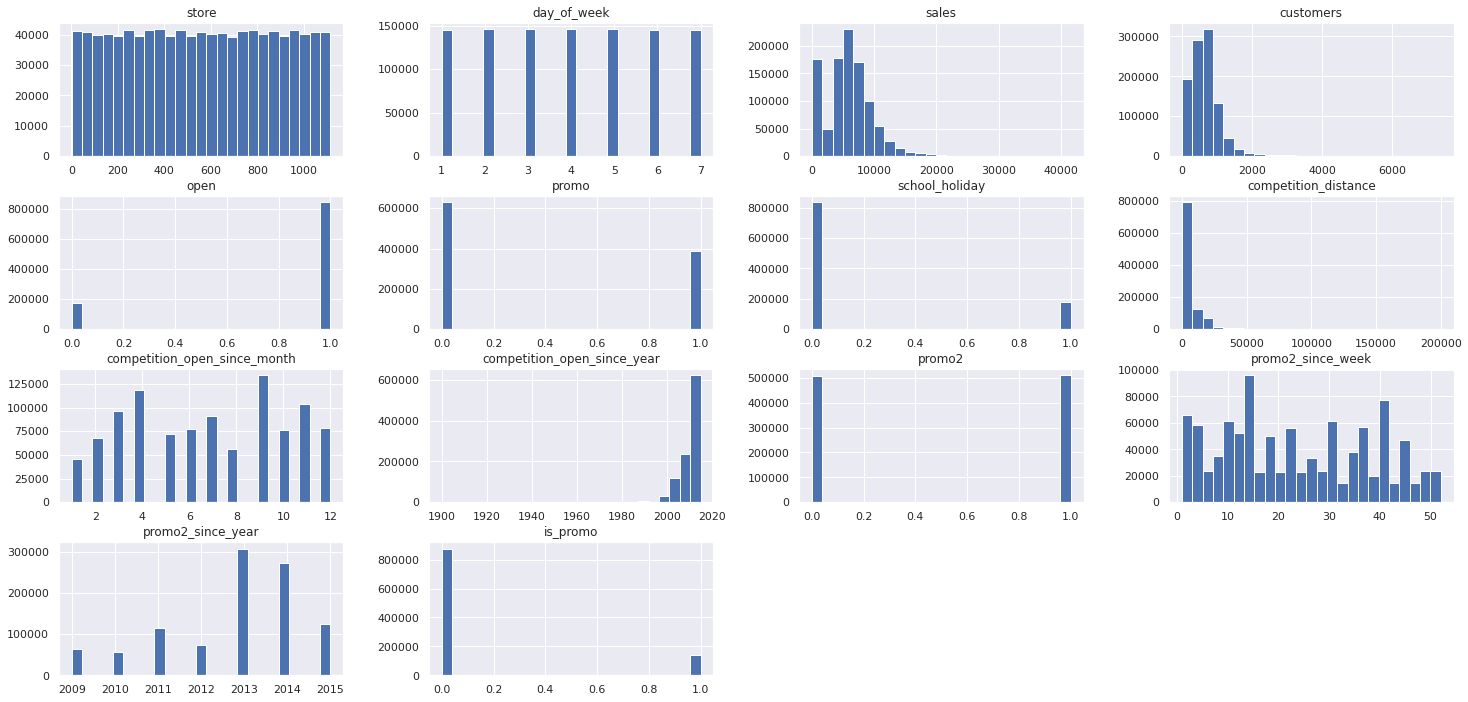

In [31]:
num_attributes.hist(bins = 25);

### 4.1.3. Categorical Variable

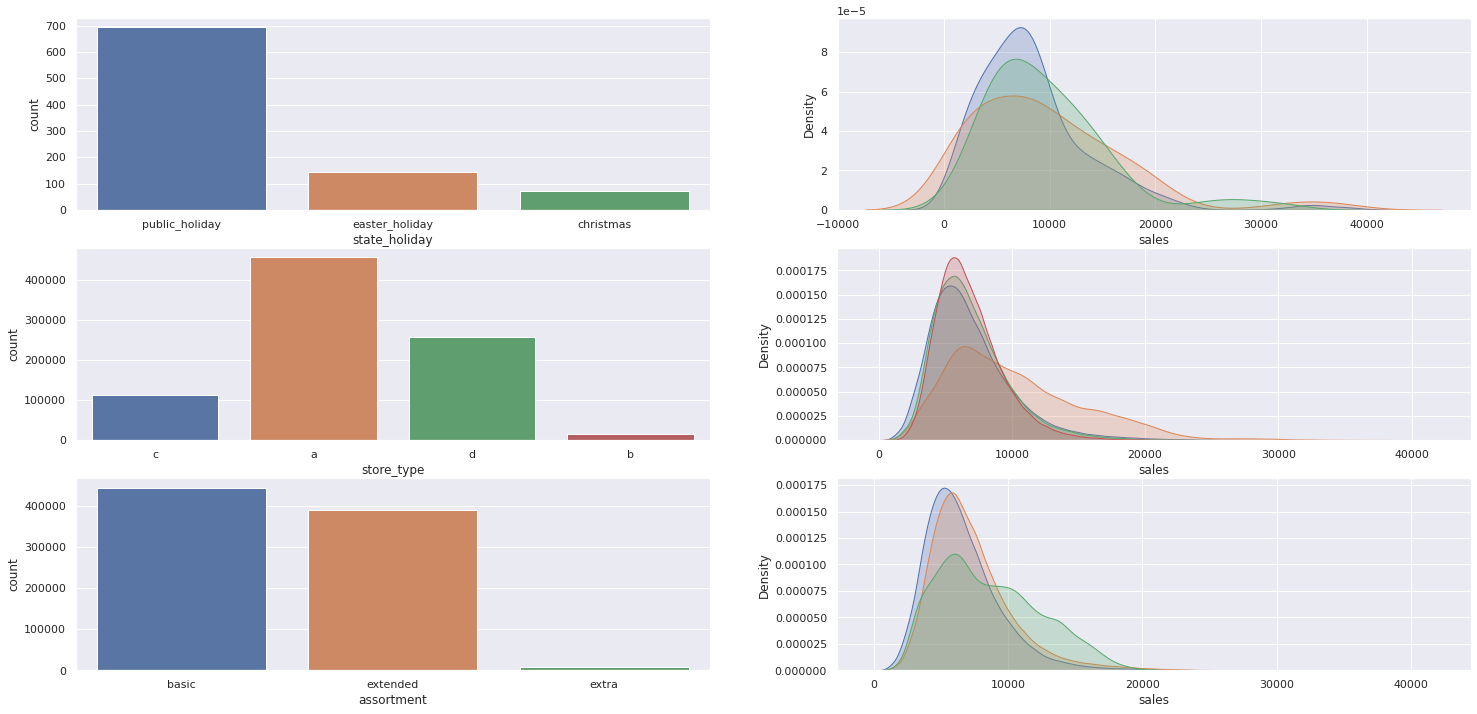

In [32]:
# state_holiday
plt.subplot( 3, 2, 1)
holidays = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x = holidays['state_holiday']);

plt.subplot( 3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],label = 'public_holiday', shade = True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],label = 'easter_holiday', shade = True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],label = 'christmas', shade = True);

# store_type
plt.subplot( 3, 2, 3)
sns.countplot(x = df4['store_type']);

plt.subplot( 3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],label = 'a', shade = True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],label = 'b', shade = True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],label = 'c', shade = True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],label = 'd', shade = True);

# assortment
plt.subplot( 3, 2, 5)
sns.countplot(x = df4['assortment']);

plt.subplot( 3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],label = 'basic', shade = True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],label = 'extended', shade = True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],label = 'extra', shade = True);

## 4.2. Bivariate Analysis

### **H1.** Stores with larger assortments should sell more.

**FALSE** Store with LARGER ASSORTMENTS sell LESS

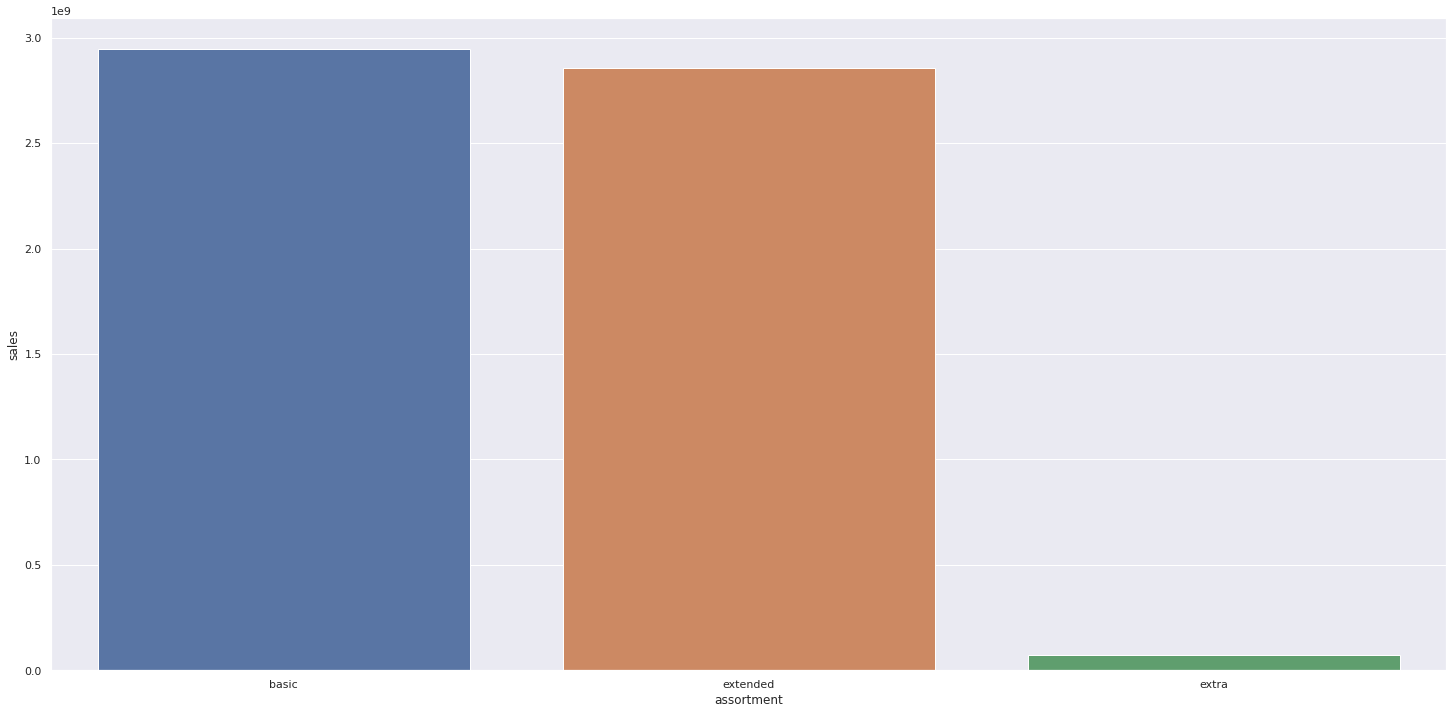

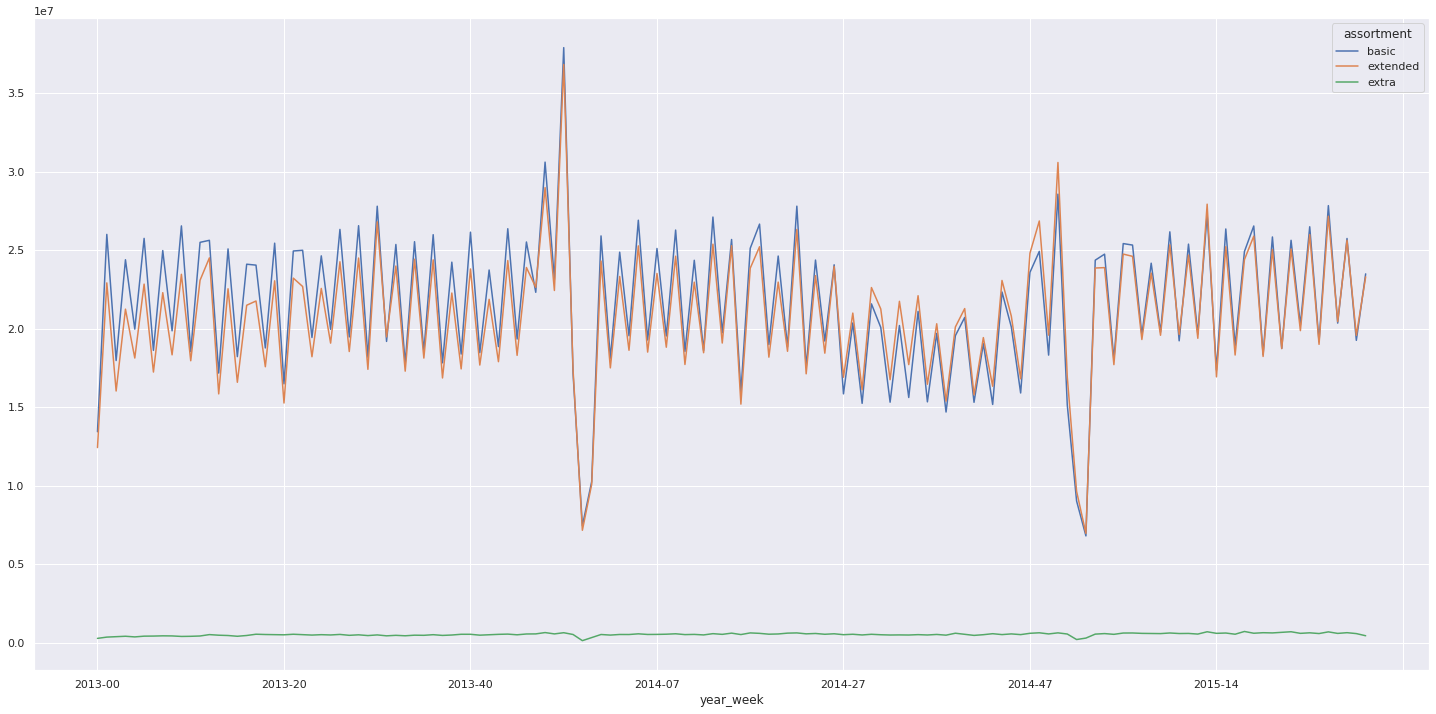

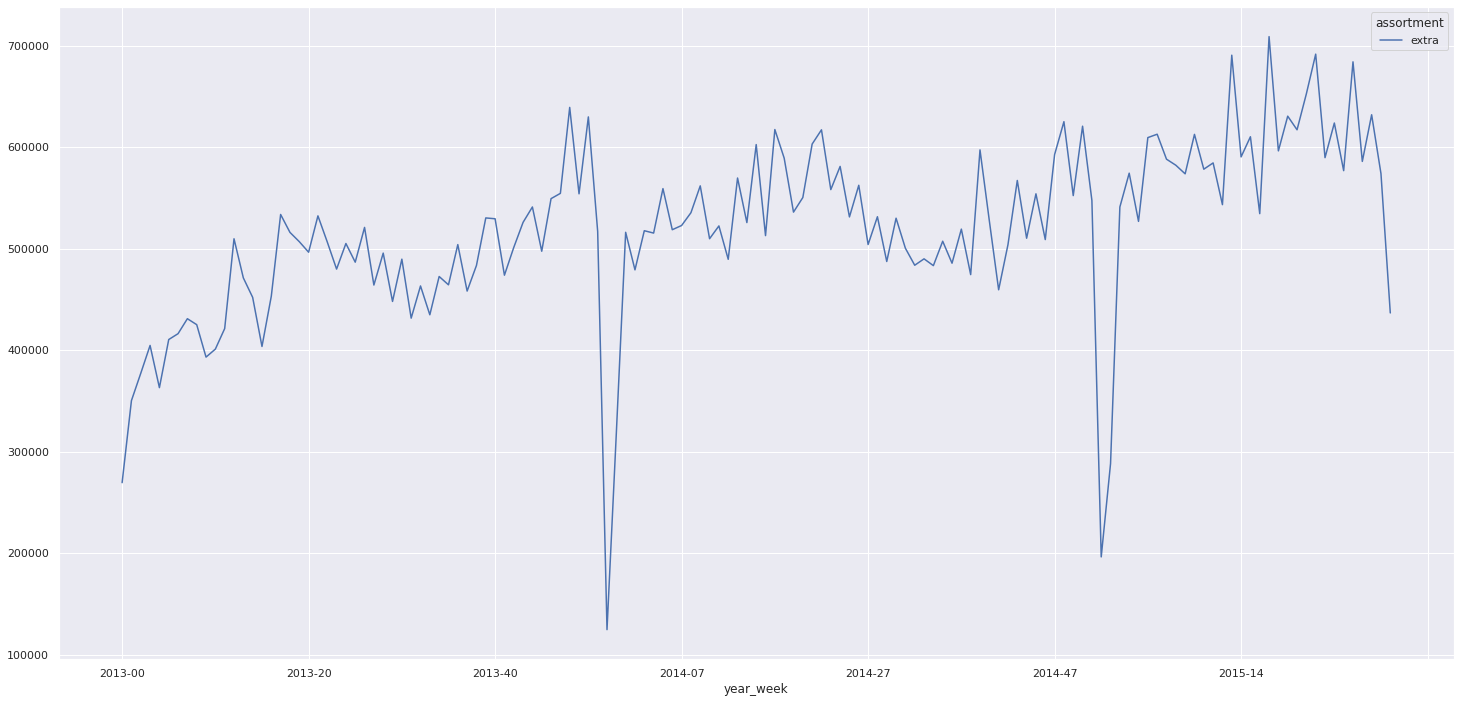

In [33]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data = aux1);

aux2 = df4[['assortment','sales','year_week']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### **H2.** Stores with closer competitors should sell less.
**FALSE** Stores with CLOSER COMPETITORS sell MORE

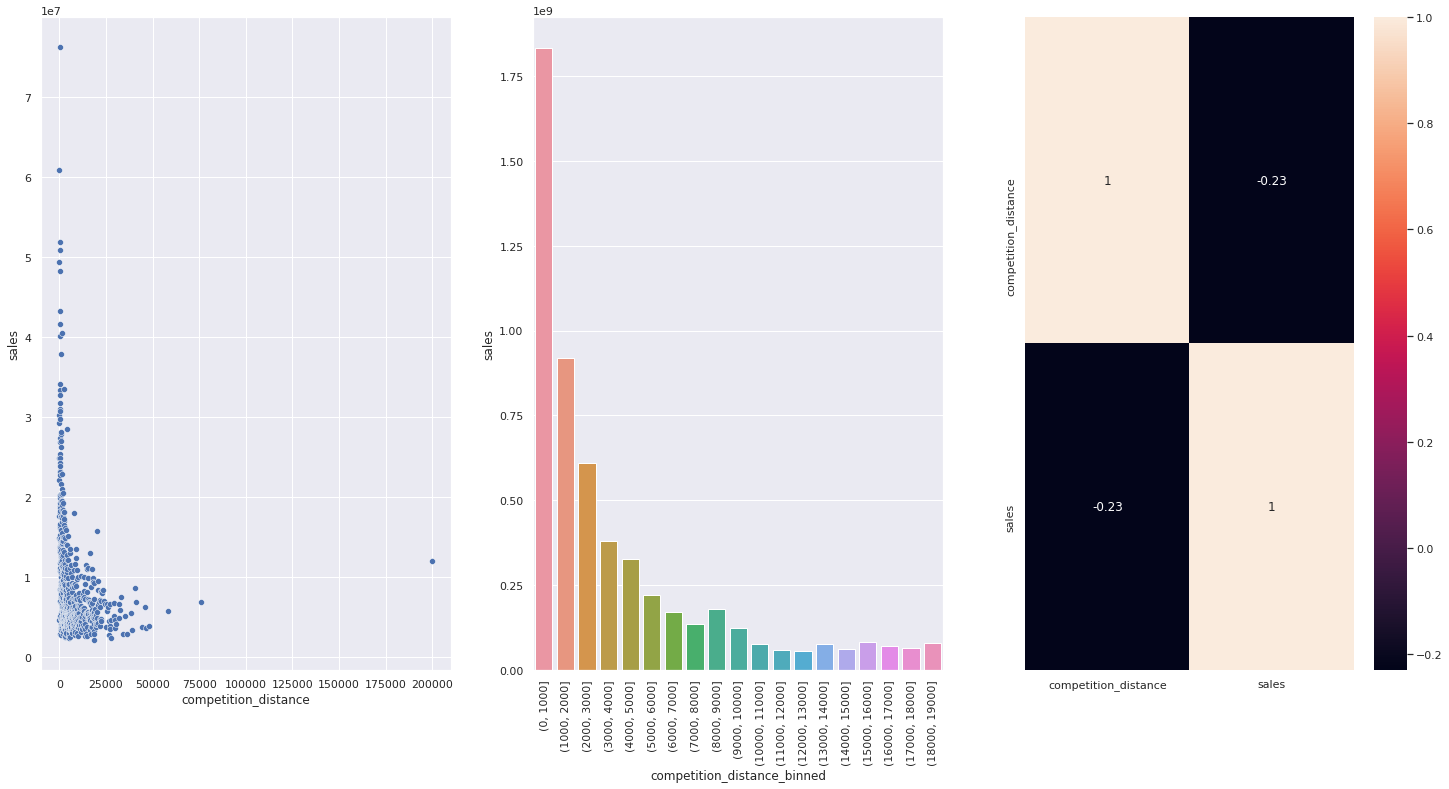

In [34]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y ='sales', data = aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0,20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned',y='sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True );

### **H3.** Stores with longer-term competitors should sell more.
**FALSE** Stores with LONG-TERM COMPETITORS sell LESS

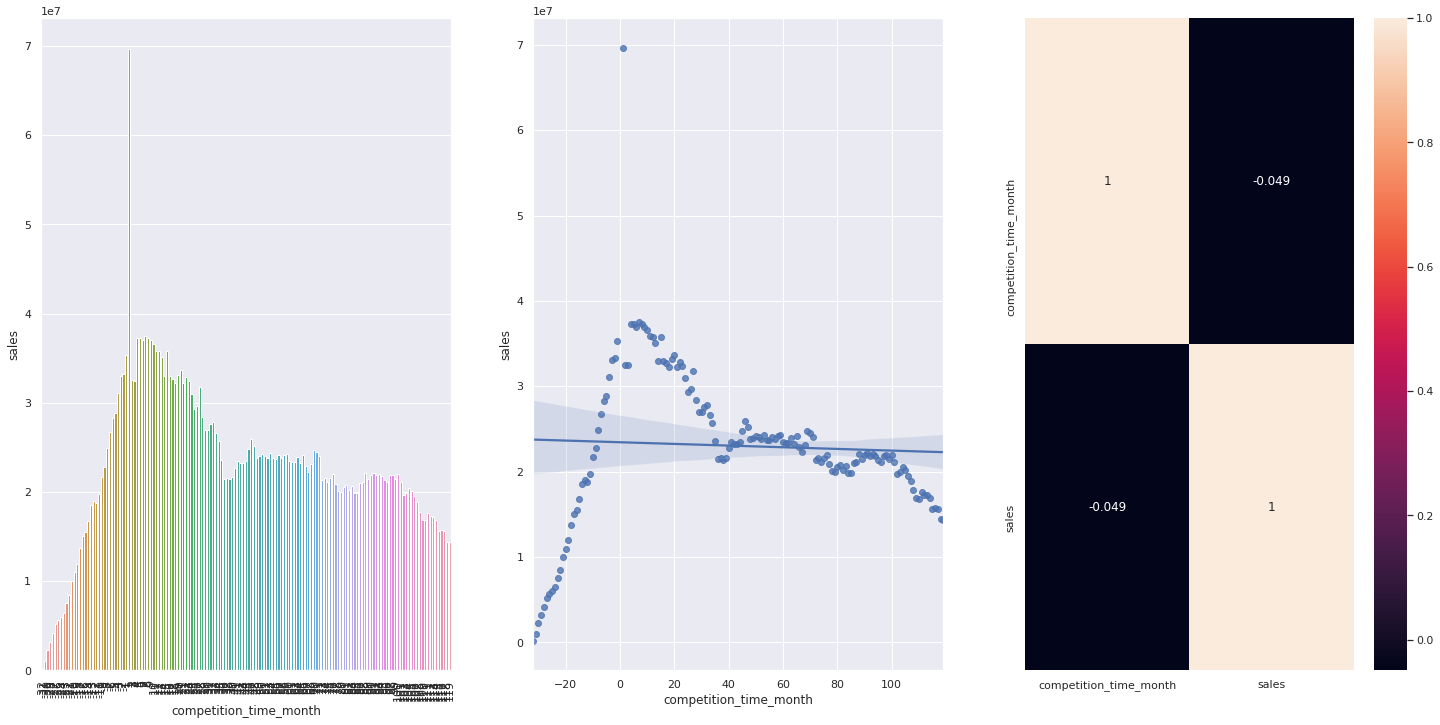

In [35]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux2.corr(method = 'pearson'), annot = True);

### **H4.** Stores with promotions active for longer should sell more.
**FALSE** Stores with PROMOTIONS ACTIVE FOR LONGER sell LESS after a promotion period.

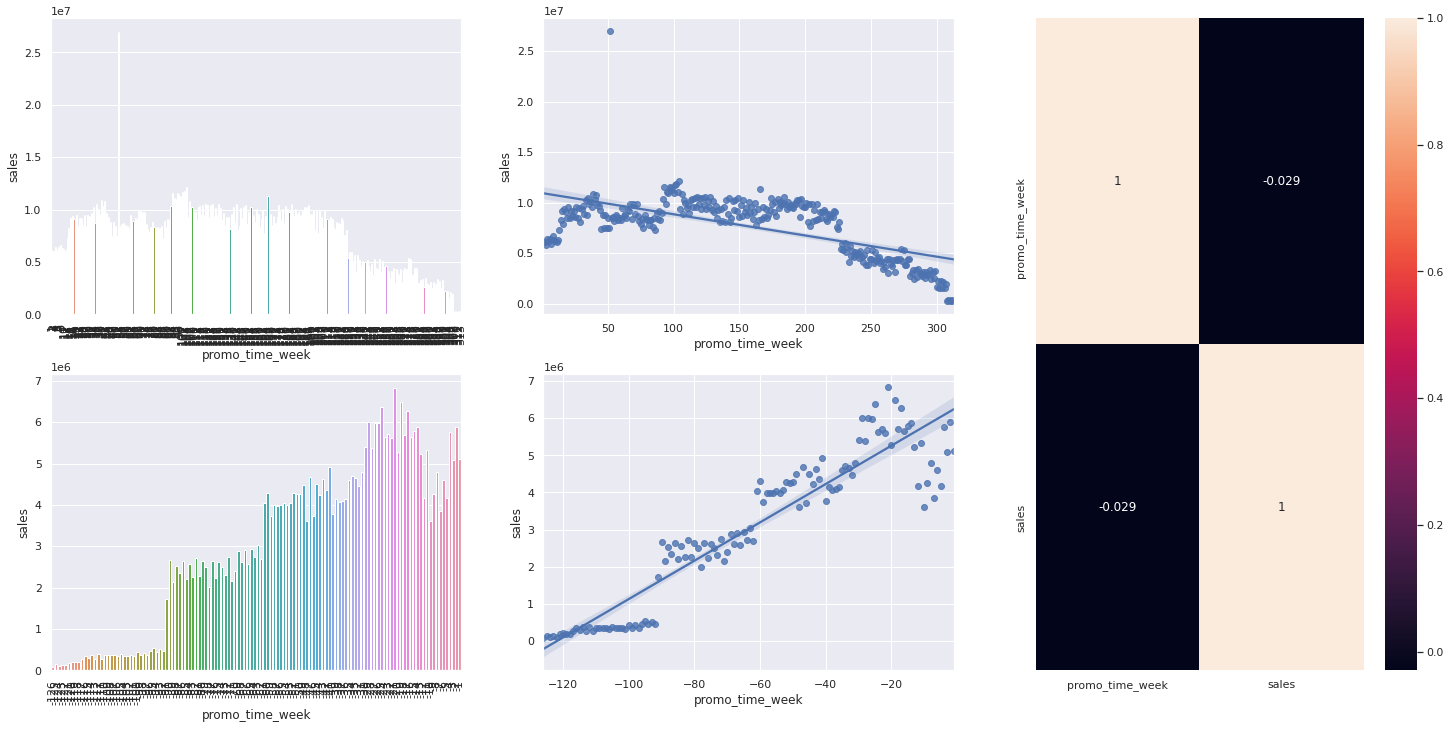

In [36]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid [0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### **H5.** Stores with more consecutive promotions should sell more.
**FALSE** Stores with MORE CONSECUTIVE PROMOTIONS sell LESS

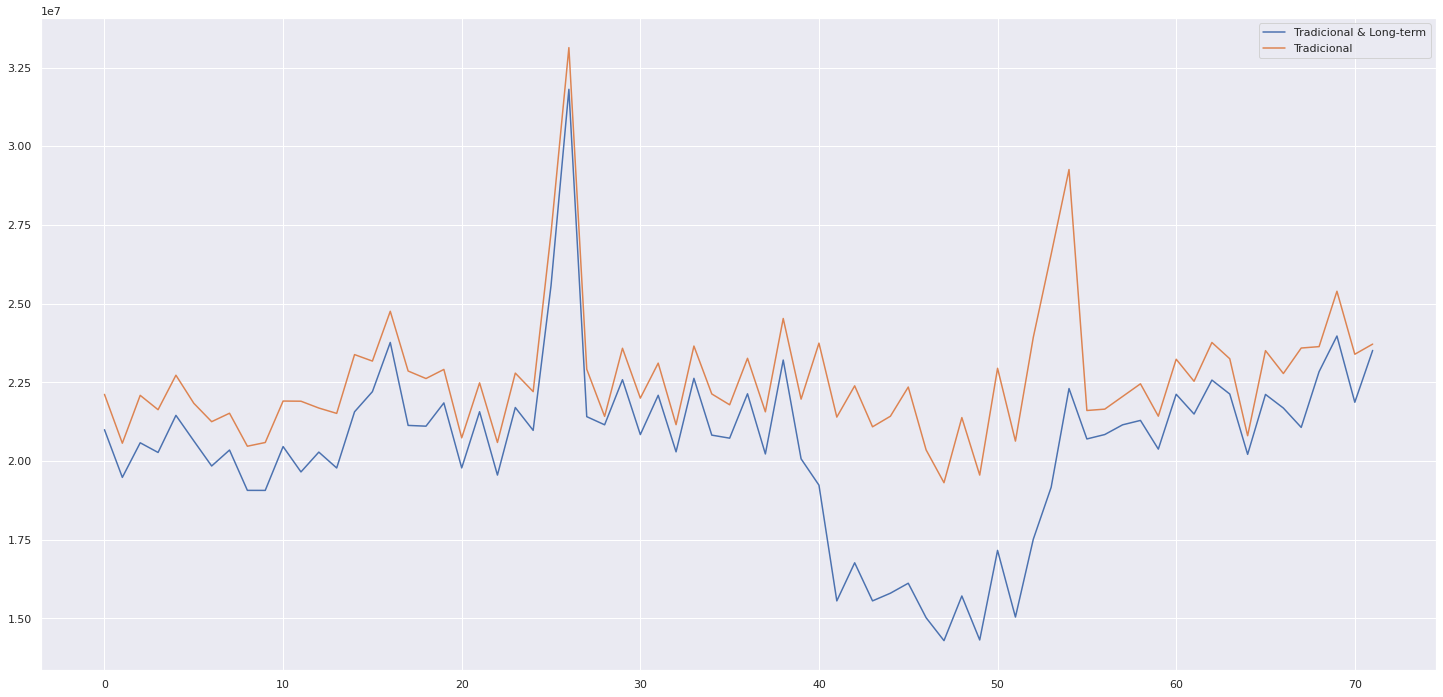

In [37]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index().sort_values('sales',ascending = False)

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

ax.legend(labels = ['Tradicional & Long-term','Tradicional']);

### **H6.** Stores open during the Christmas holiday should sell more..
**FALSE** Stores open during THE CHRISTMAS HOLIDAY sell LESS.

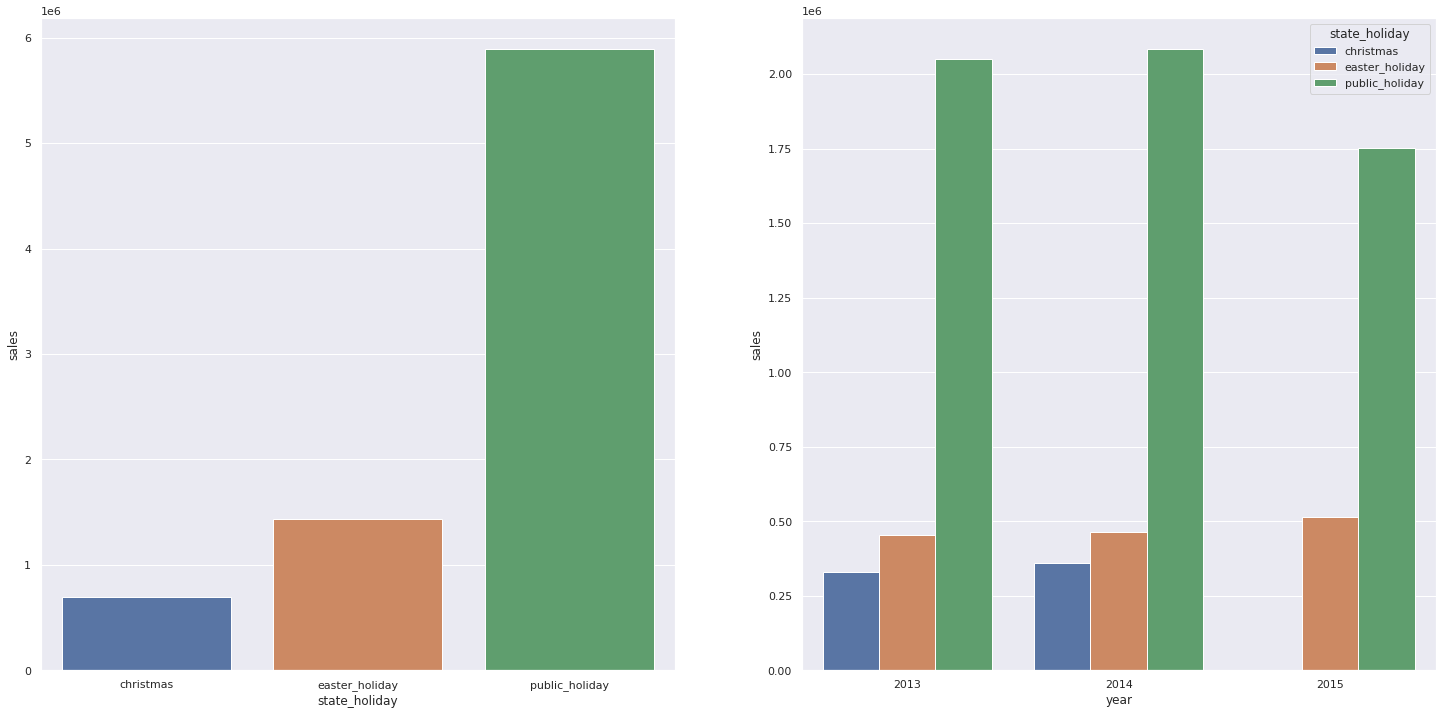

In [38]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales',hue = 'state_holiday', data = aux2);

### **H7.** Stores should sell more over the years.
**FALSE** Stores SELL less OVER THE YEARS.

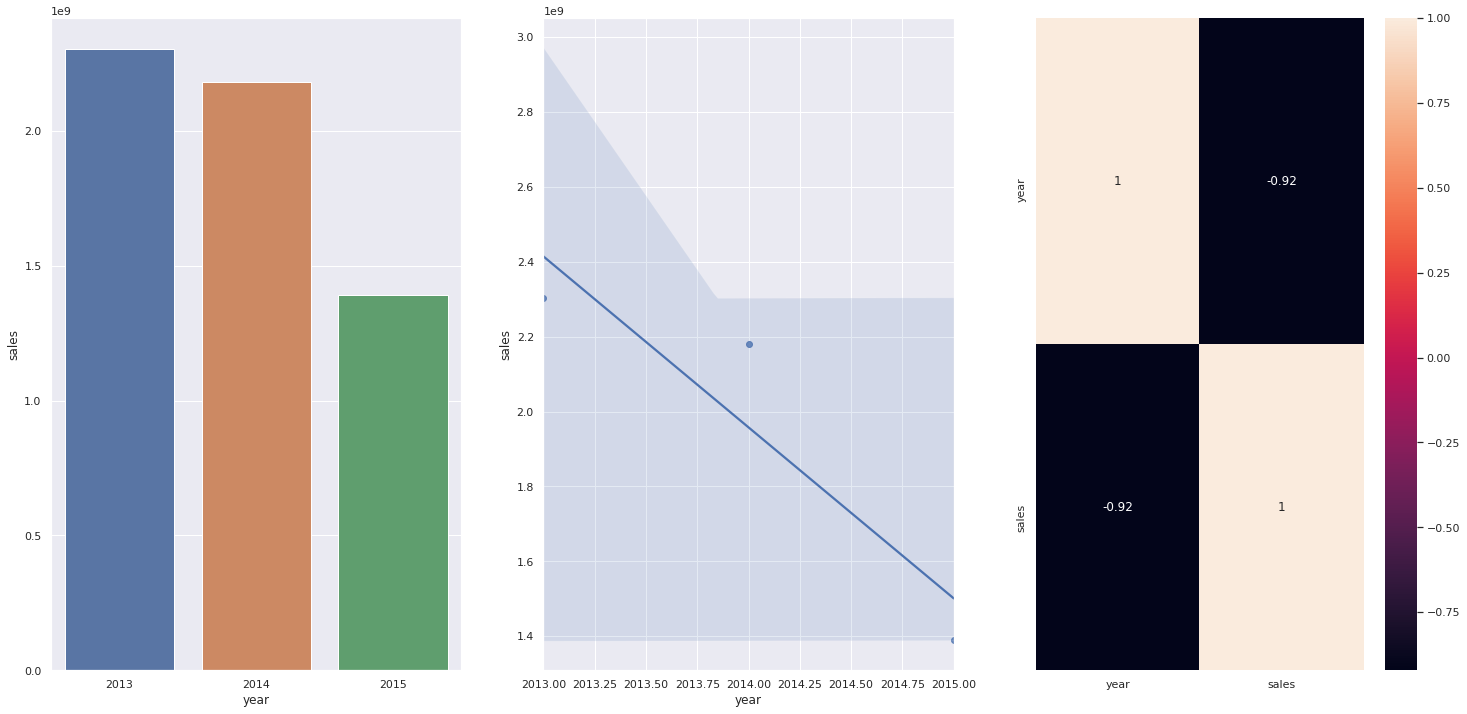

In [39]:
plt.subplot(1,3,1)
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot = True);

### **H8.** Stores should sell more in the second half of the year.
**FALSE** Stores SELL less IN THE SECOND HALF OF THE YEAR.

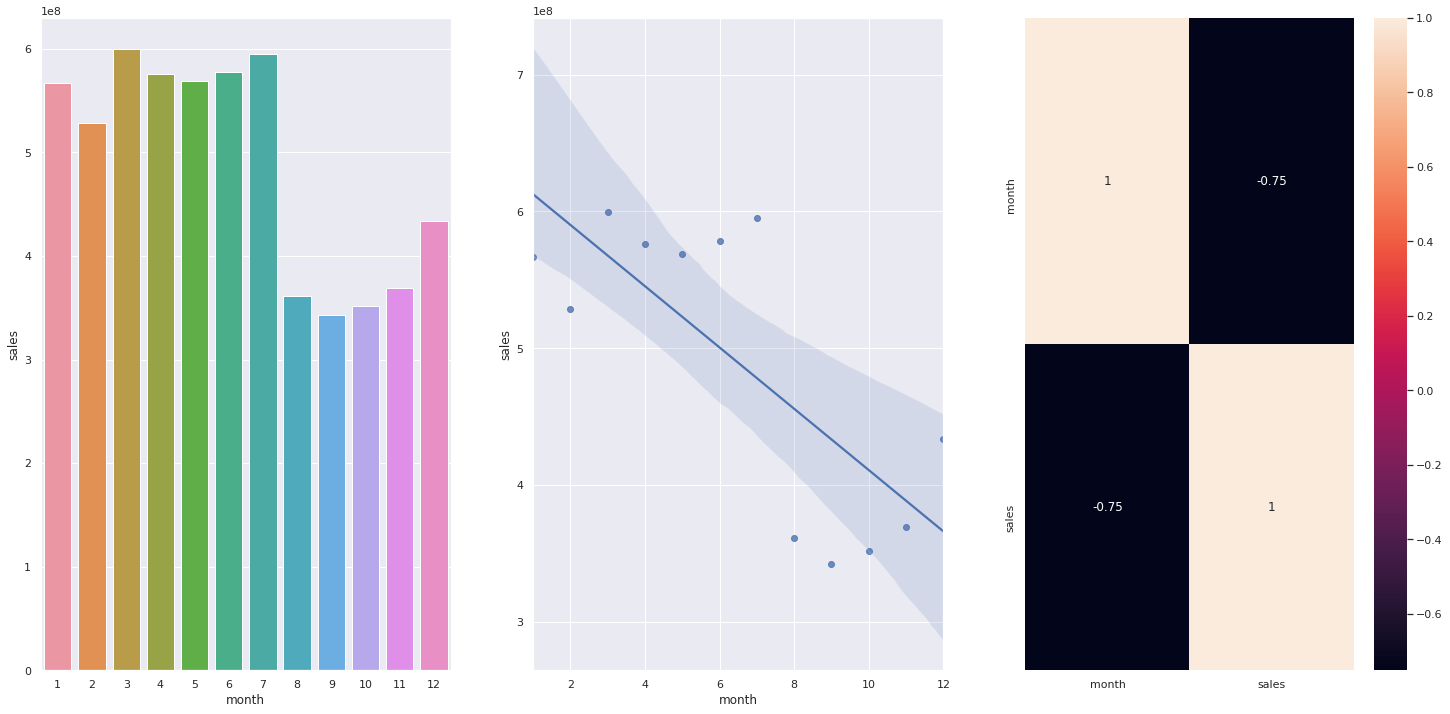

In [40]:
plt.subplot(1,3,1)
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot = True);

### **H9.** Stores should sell more after the 10th of each month..
**TRUE** Stores SELL more AFTER THE 10TH OF EACH MONTH.

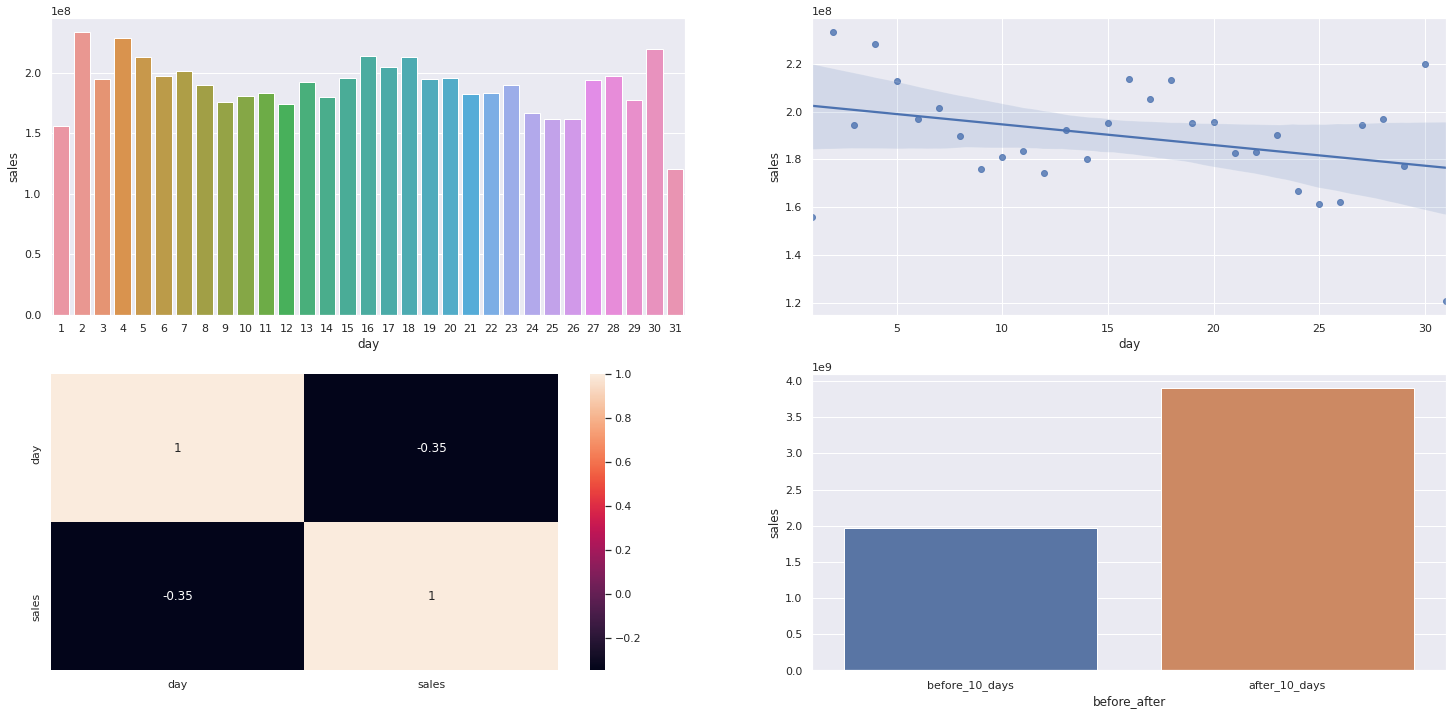

In [41]:
plt.subplot(2,2,1)
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot = True);


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data = aux2, order = aux2.sort_values('sales').before_after);

### **H11.** Stores should sell less on weekends.
**TRUE** Stores SELL less ON WEEKENDS.

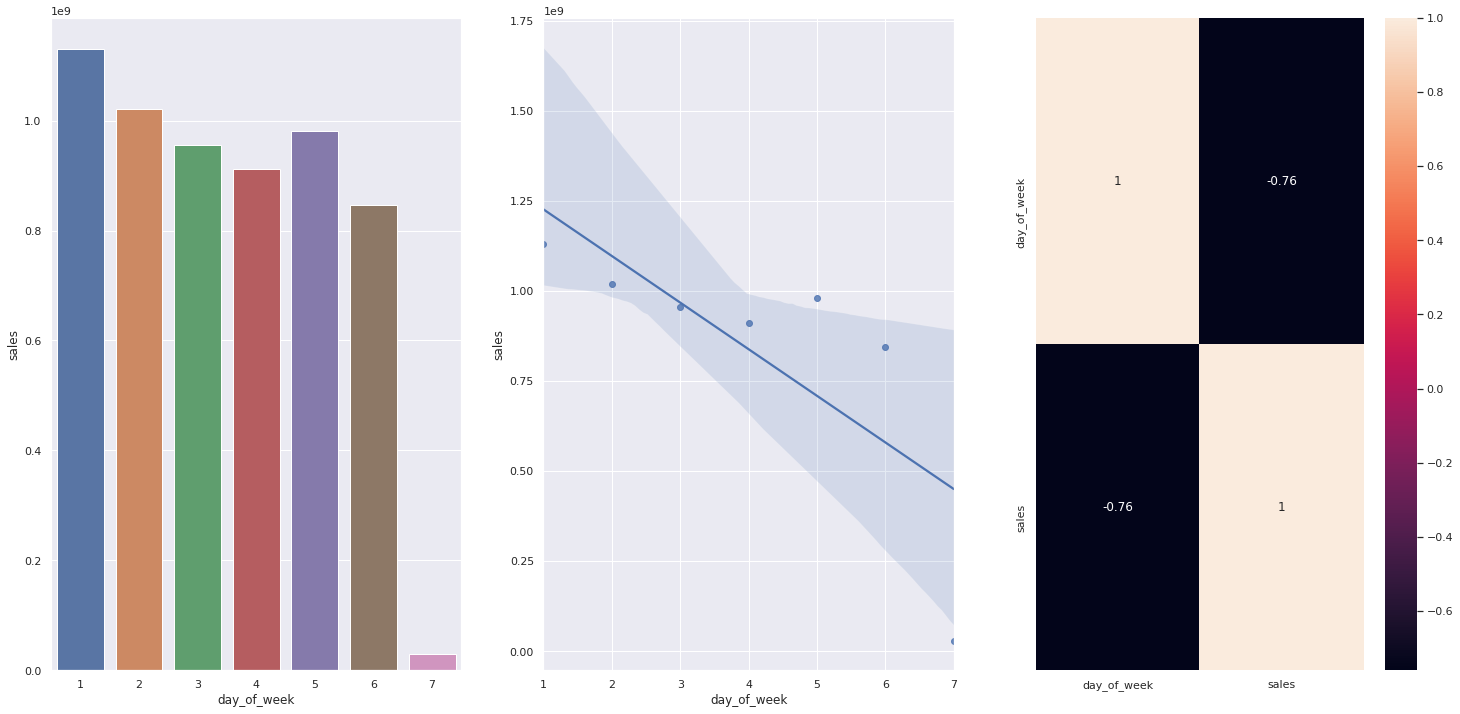

In [42]:
plt.subplot(1,3,1)
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot = True);

### **H11.** Stores should sell less during school holidays.
**TRUE** Stores SELL less DURING SCHOOL HOLIDAYS, except in July and August

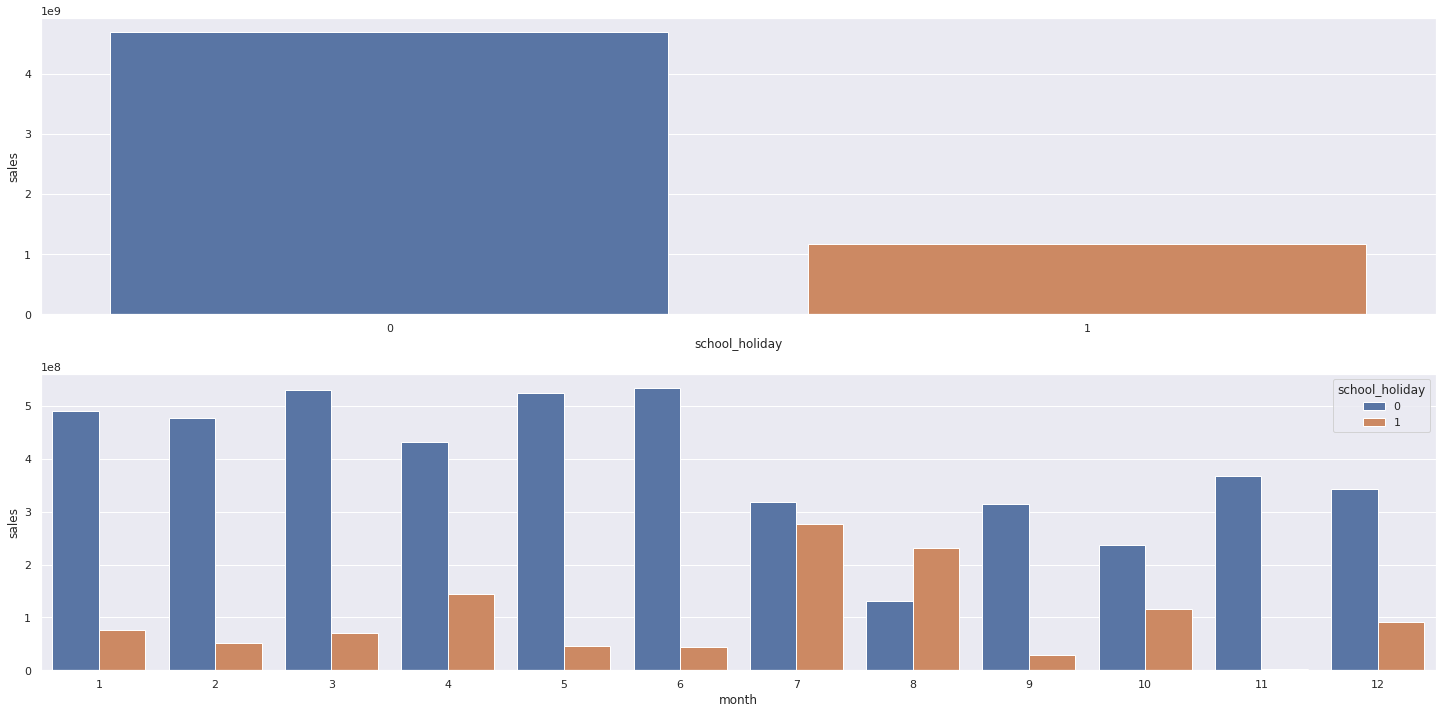

In [43]:
plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data = aux1);

plt.subplot(2, 1, 2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue = 'school_holiday', data = aux2);

### 4.2.1 Hypotheses summary

In [44]:
tab = [['Hipothesis', 'Conclusion', 'Relevance'],
      ['H1','False','Low'],
      ['H2','False','Average'],
      ['H3','False','Average'],
      ['H4','False','Low'],
      ['H5','False','Low'],
      ['H6','False','Average'],
      ['H7','False','High'],
      ['H8','False','High'],
      ['H9','True','High'],
      ['H10','True','High'],
      ['H11','True','Low']
      ]
print(tabulate(tab, headers = 'firstrow'))

Hipothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Average
H3            False         Average
H4            False         Low
H5            False         Low
H6            False         Average
H7            False         High
H8            False         High
H9            True          High
H10           True          High
H11           True          Low


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

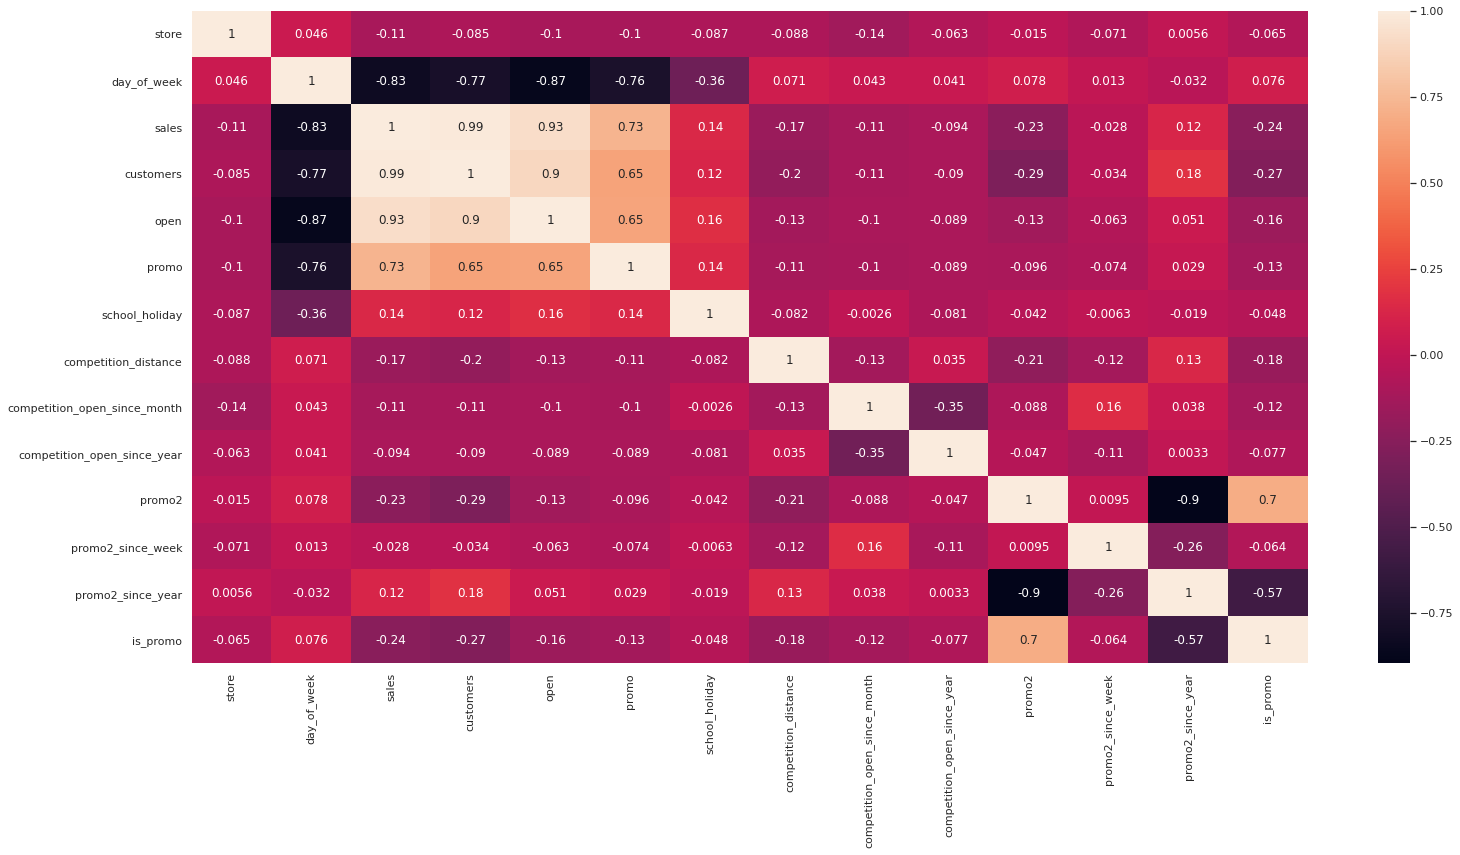

In [45]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation.corr(method = 'pearson'),annot = True);

### 4.3.2. Categorical Attributes

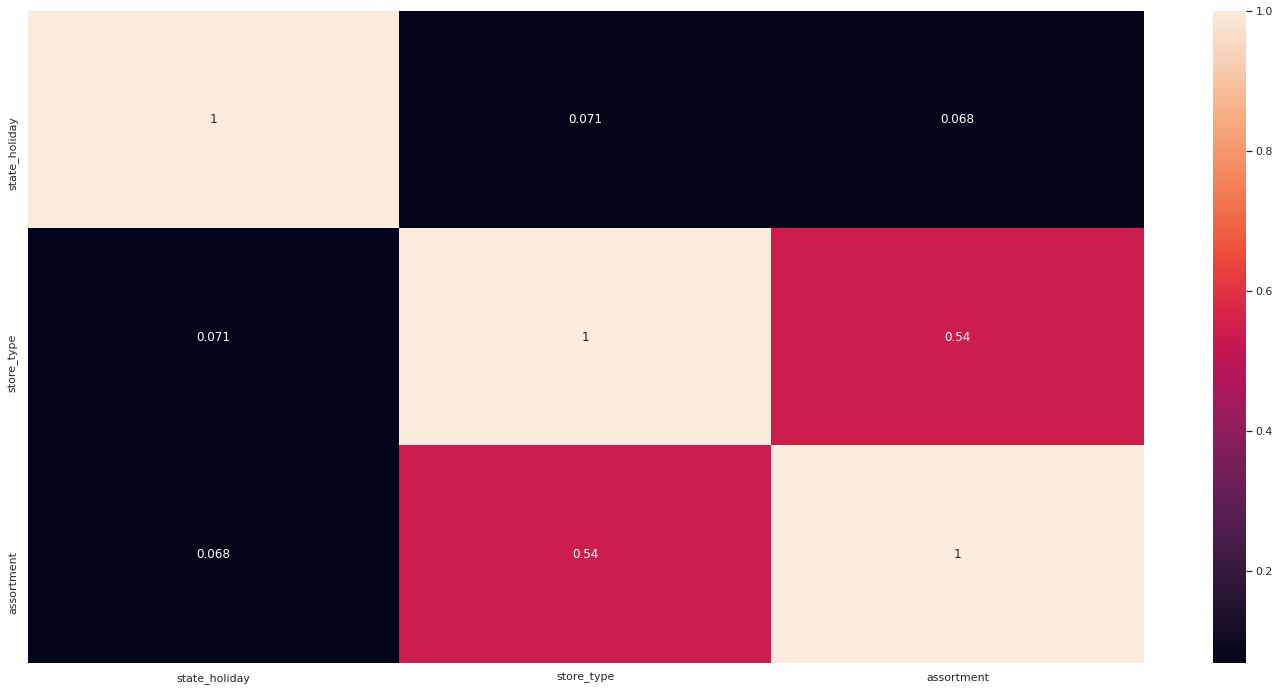

In [46]:
a = df4.select_dtypes(include = 'object' )

# calculate cramer V
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

# final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9] })

d = d.set_index(d.columns)

sns.heatmap(d, annot = True);

# 5.0. DATA PREPARATION

In [47]:
df5 = df4.copy()

## 5.1. Normalization

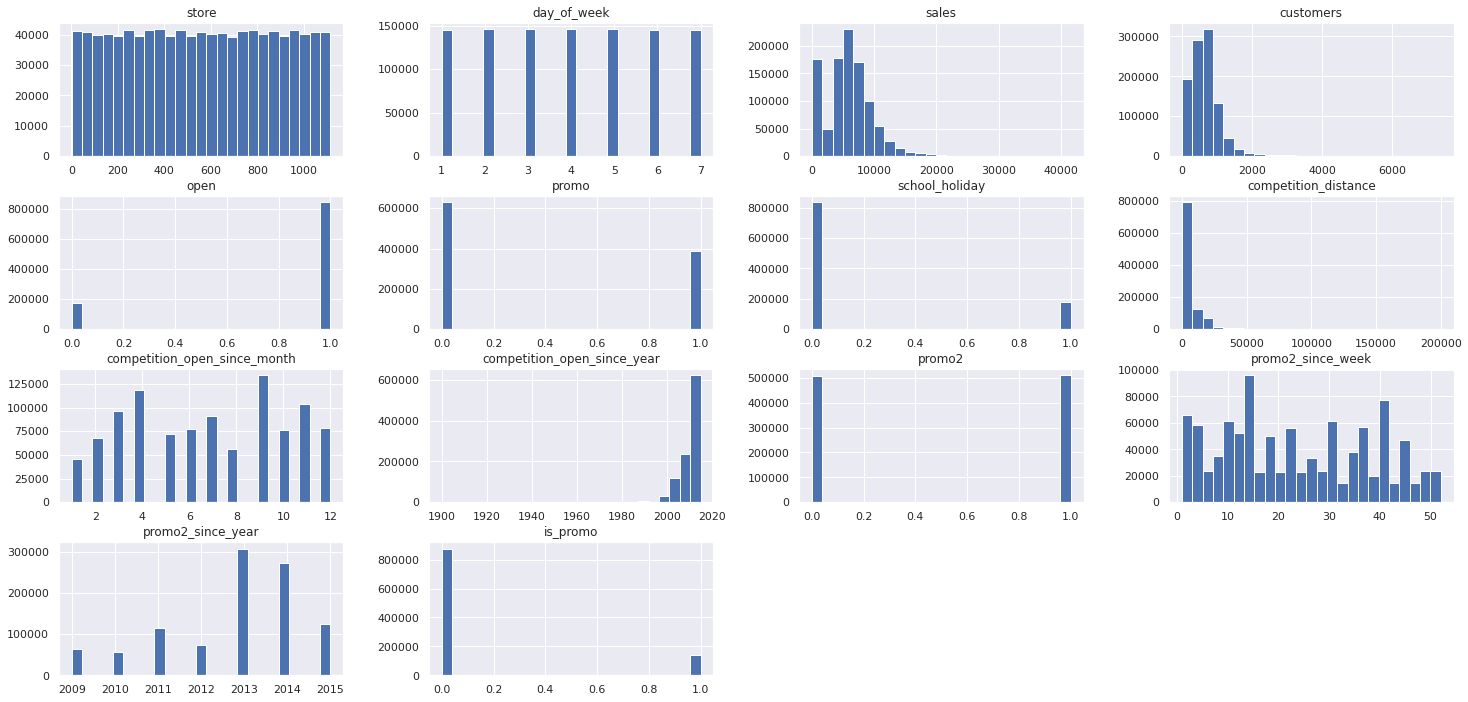

In [48]:
num_attributes.hist(bins = 25);

## 5.2. Rescaling

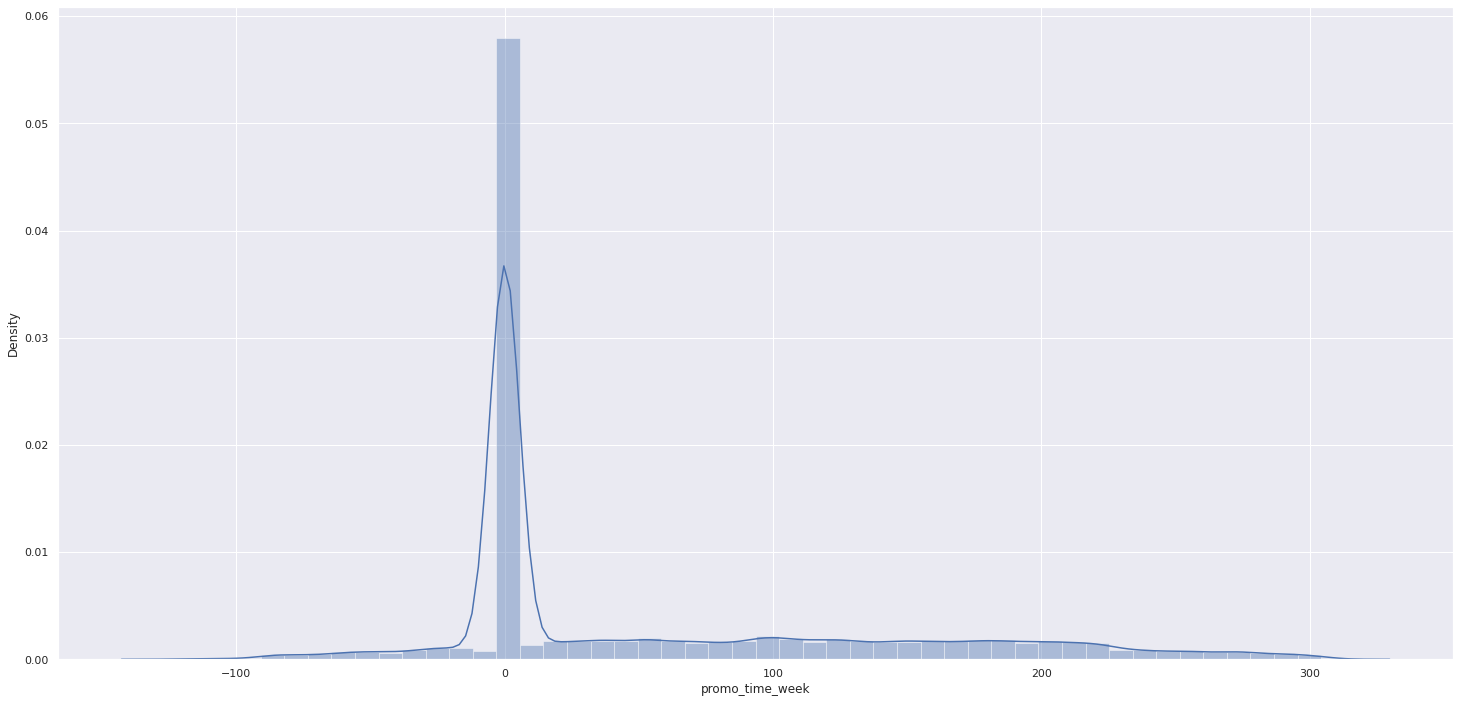

In [49]:
sns.distplot(df5['promo_time_week']);

In [50]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl','wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl','wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl','wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl','wb'))

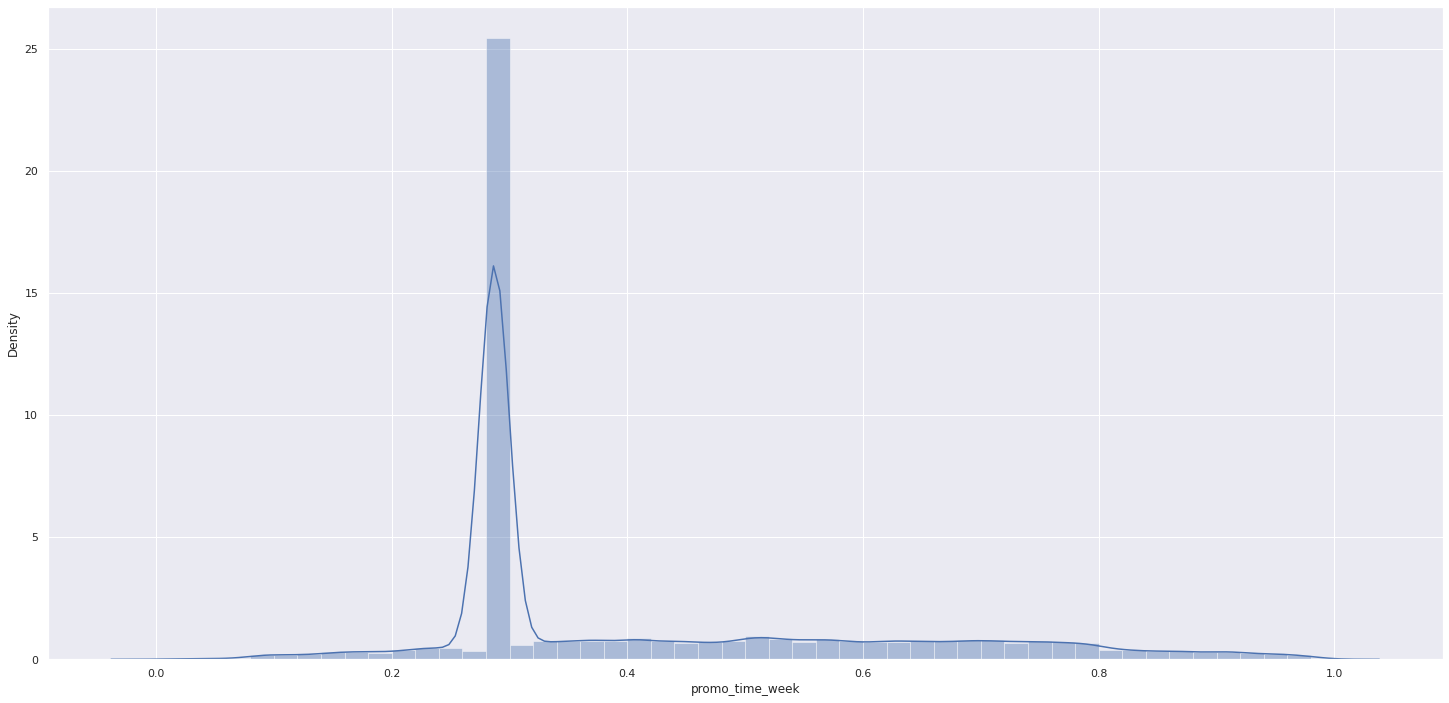

In [51]:
sns.distplot(df5['promo_time_week']);

## 5.3. Transformation

### 5.3.1. Encoding

In [52]:
df5[['store_type','assortment','state_holiday']].head()

,store_type,assortment,state_holiday
0,c,basic,regular_day
1,a,basic,regular_day
2,a,basic,regular_day
3,c,extended,regular_day
4,a,basic,regular_day


In [53]:
# state_holiday
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns = ['state_holiday'] )

# store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
# pickle.dump(le, open('parameter/store_type_scaler.pkl','wb'))

# assortment
assortment_dict = {'basic':1, 'extra':2,'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [54]:
df5[['store_type','assortment','state_holiday_christmas', 'state_holiday_easter_holiday',
       'state_holiday_public_holiday', 'state_holiday_regular_day']].head()

,store_type,assortment,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,2,1,0,0,0,1
1,0,1,0,0,0,1
2,0,1,0,0,0,1
3,2,3,0,0,0,1
4,0,1,0,0,0,1


### 5.3.2. Response Variable Transformation

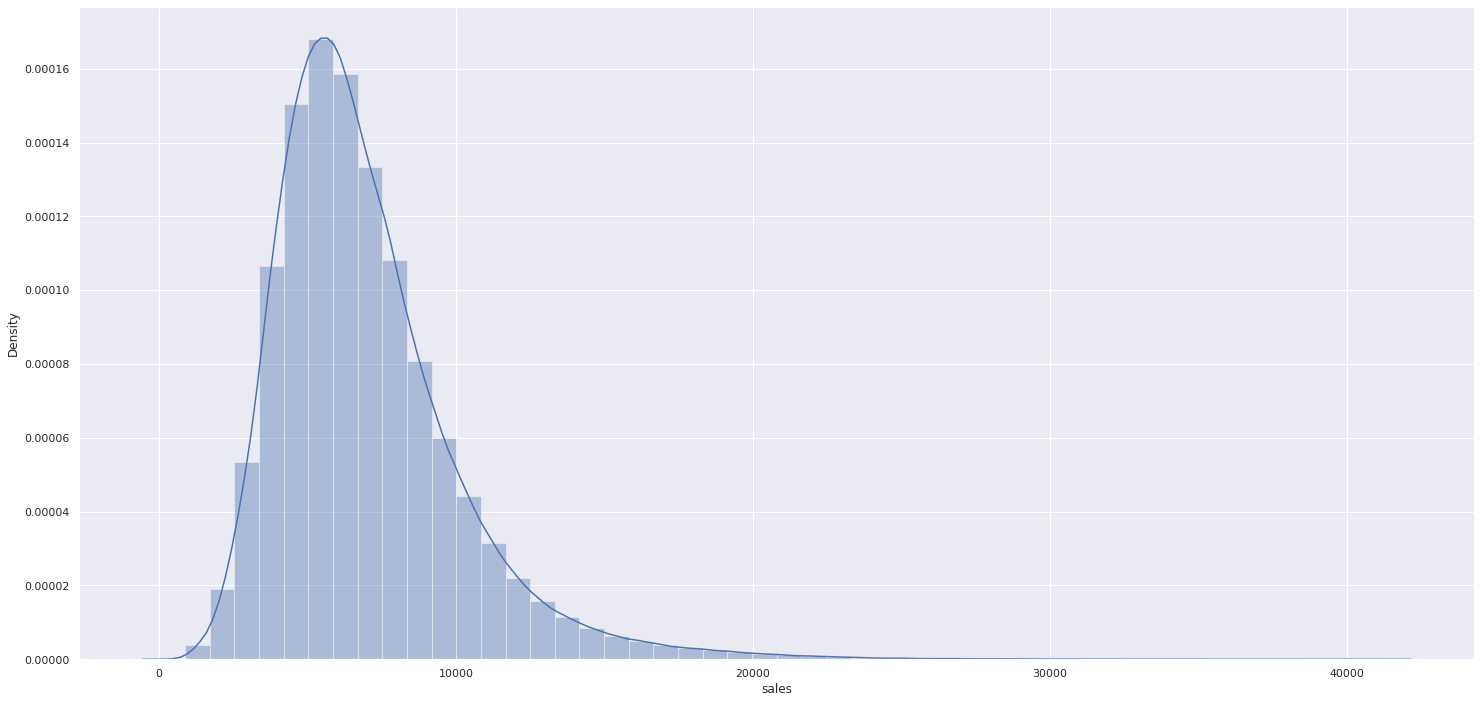

In [55]:
sns.distplot(df5['sales']);

In [56]:
df5['sales'] = np.log1p(df5['sales'])

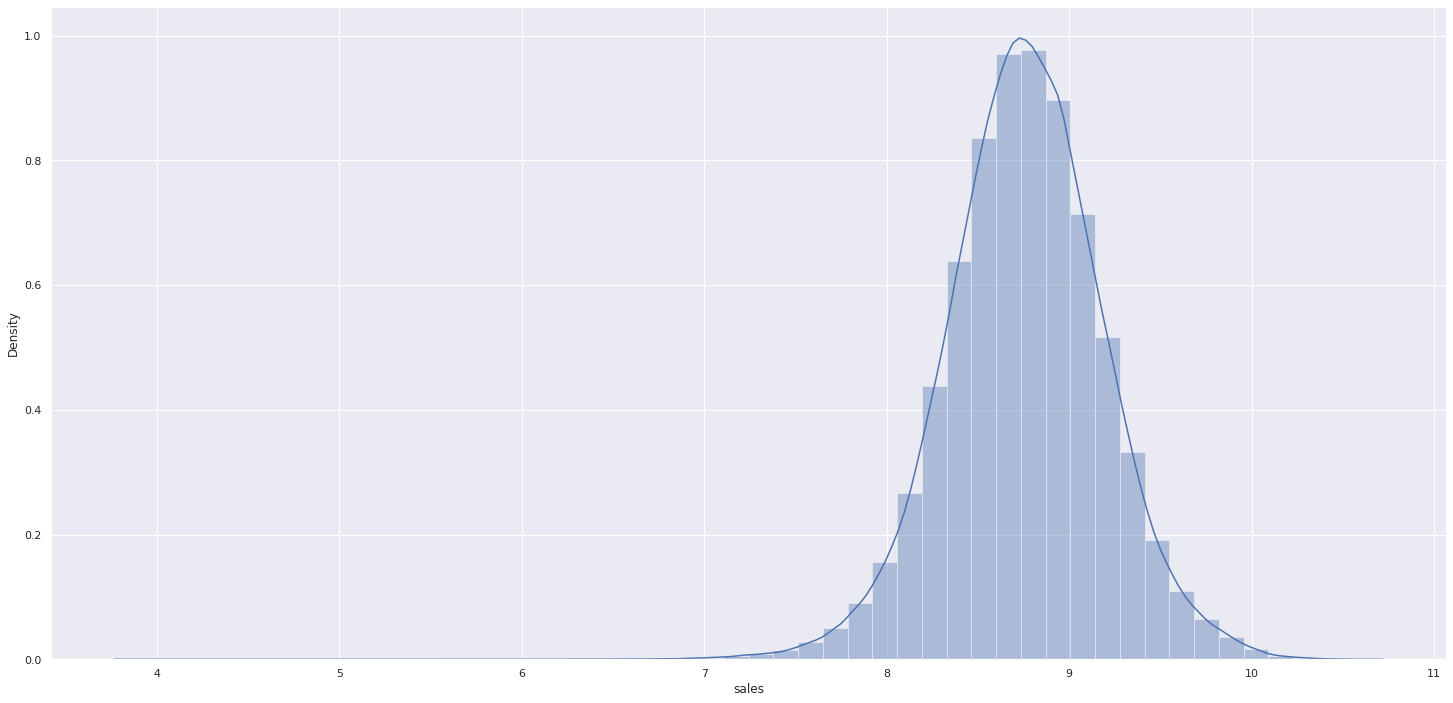

In [57]:
sns.distplot(df5['sales']);

### 5.3.3. Nature Transformation

In [58]:
df5[['day_of_week','month','day','week_of_year']].head()

,day_of_week,month,day,week_of_year
0,5,7,31,31
1,5,7,31,31
2,5,7,31,31
3,5,7,31,31
4,5,7,31,31


In [59]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7) ) )

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52) ) )

In [60]:
df5[['day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos']].head()

,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. FEATURE SELECTION

In [61]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [62]:
cols_drop = ['day_of_week','month','day','week_of_year','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [63]:
# minimum date of store record
date_min = df6[['date','store']].groupby('store').min().reset_index()

date_min['date'].min()

Timestamp('2013-01-01 00:00:00')

In [64]:
# maximum date of store record
date_max = df6[['date','store']].groupby('store').max().reset_index()

date_max['date'].max()

Timestamp('2015-07-31 00:00:00')

In [65]:
# Find the corresponding date to six weeks before the end
df6[['date','store']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days= 6*7)

Timestamp('2015-06-19 00:00:00')

In [66]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min() ) )
print('Training Max Date: {}'.format(X_train['date'].max() ) )


print('\nTest Min Date: {}'.format(X_test['date'].min() ) )
print('Test Max Date: {}'.format(X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [67]:
# # training and test dataset for Boruta
# X_train_n = X_train.drop(['date','sales'], axis = 1).values
# Y_train_n = Y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs = -1)

# # define boruta
# boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit(X_train_n,Y_train_n)

### 6.2.1. Best Features from Boruta

In [68]:
# cols_selected = boruta.support_.to_list()

# # best features
# X_train_fs = X_train.drop(['date','sales'],axis = 1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list(np.settdif1d( X_train_fs.columns, cols_selected_boruta ))

## 6.3. Manual Feature Selection

In [69]:
cols_selected_boruta =  [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_cos',
    'day_sin',
    'day_cos', 
    'week_of_year_cos']

<center>

### Comparing Features Selected by Boruta with those Selected by Exploratory Data Analysis
    
</center>

In [70]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [71]:
tab = [['Hipothesis', 'Attribute','Relevance'],
      ['H1','assortment','Low'],
      ['H2','competition_distance','Average'],
      ['H3','competition_time_month','Average'],
      ['H4','promo_time_week','Low'],
      ['H5','promo2','Low'],
      ['H6','state_holiday','Average'],
      ['H7','year','High'],
      ['H8','month','High'],
      ['H9','day','High'],
      ['H10','day_of_week','High'],
      ['H11','school_holiday','Low']
      ]
print(tabulate(tab, headers = 'firstrow'))

Hipothesis    Attribute               Relevance
------------  ----------------------  -----------
H1            assortment              Low
H2            competition_distance    Average
H3            competition_time_month  Average
H4            promo_time_week         Low
H5            promo2                  Low
H6            state_holiday           Average
H7            year                    High
H8            month                   High
H9            day                     High
H10           day_of_week             High
H11           school_holiday          Low


In [72]:
# Adding 'month_sin' and 'week_of_year_sin' features
cols_selected_boruta =  [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos', 
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add to create the final features
feat_to_add = ['date','sales']

# final features with date and sales
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [73]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# 7.0. MACHINE LEARNING MODELLING

In [74]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [75]:
# training dataset
train = x_train.copy()
train['sales'] = y_train.copy()

# testing dataset
test = x_test.copy()
test_sales = y_test.copy() 

# prediction
# sales average per store on the training period
avg_sales_train = train[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'}) 

# forecast
forecast = pd.merge(test, avg_sales_train, how='left', on='store')
baseline = forecast['predictions'] # sales forecast series

# performance
baseline_result = ml_error('Average Model', np.expm1(test_sales), np.expm1(baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1429.763326,0.44785,1939.32873


## 7.2. Linear Regression Model

In [76]:
# model
lr = LinearRegression().fit( x_train, y_train ) 

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [77]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [78]:
# model
lrr = Lasso( alpha = 0.01 ).fit( x_train, y_train ) 

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Linear Regression Regularized Model - Lasso - Cross Validation

In [79]:
lrr_result_cv = cross_validation( x_training, 5, 'Linear Regression - Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [80]:
# model
# rf = RandomForestRegressor( n_estimators=100, n_jobs=1, random_state=42 ).fit( x_train, y_train ) 

# prediction
# yhat_rf = rf.predict( x_test )

# performance
# rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
# rf_result

# saving on pickle
# pickle.dump(rf_result, open('model/random_forest_result.pkl','wb'))

In [81]:
# Random Forest result
file = open('model/random_forest_result.pkl', 'rb')
rf_result = pickle.load(file)
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738


### 7.4.1. Random Forest Regressor - Cross Validation

In [82]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=False )
# rf_result_cv

# saving on pickle
# pickle.dump(rf_result_cv, open('model/random_forest_result_cv.pkl','wb'))

In [83]:
# Random Forest Cross Validation result
file = open('model/random_forest_result_cv.pkl', 'rb')
rf_result_cv = pickle.load(file)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28


## 7.5. XGBoost Regressor

In [84]:
# model
# model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                              n_estimator=100,
#                              eta = 0.01,
#                              max_depth = 10,
#                              subsample = 0.7,
#                              colssample_bytee = 0.9 ).fit( x_train, y_train ) 

# prediction
# yhat_xgb = model_xgb.predict( x_test )

# # performance
# xgb_result = ml_error( 'XBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb)
# xgb_result

# saving on pickle
# pickle.dump(xgb_result, open('model/xgb_result.pkl','wb'))

In [85]:
# XGBoost Regressor result
file = open('model/xgb_result.pkl', 'rb')
xgb_result = pickle.load(file)
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XBoost Regressor,843.112293,0.122609,1250.952637


### 7.5.1. XGBoost Regressor - Cross Validation

In [86]:
# model_xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )
# model_xgb_result_cv

# saving on pickle
# pickle.dump(model_xgb_result_cv, open('model/model_xgb_result_cv.pkl','wb'))

In [87]:
# XGBoost Regressor Cross Validation result
file = open('model/xgb_result_cv.pkl', 'rb')
model_xgb_result_cv = pickle.load(file)
model_xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [88]:
modelling_result = pd.concat( [baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738
0,XBoost Regressor,843.112293,0.122609,1250.952637
0,Average Model,1429.763326,0.447850,1939.328730
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2. Real Performance - Cross Validation

In [89]:
# analyzing real performance with average model
modelling_result_cv = pd.concat( [lr_result_cv,lrr_result_cv,rf_result_cv,model_xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Linear Regression - Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


# 8.0. HYPERPARAMETER FINE TUNNING


## 8.1. Random Search

In [90]:
# param = {
#     'n_estimators': [1500, 1700, 2500, 3000, 3500],
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytree': [0.3, 0.7, 0.9],
#     'min_child_weight': [3, 8, 15]}

# MAX_EVAL = 10

In [91]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
#     # choose values for parameters randomly
#     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#     print( hp )

#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                               n_estimators=hp['n_estimators'],
#                               eta = hp['eta'],
#                               max_depth = hp['max_depth'],
#                               subsample = hp['subsample'],
#                               colsample_bytree = hp['colsample_bytree'],
#                               min_child_weight= hp['min_child_weight'])

#     # performance
#     result = cross_validation( x_training, 5, 'XBoost Regressor', model_xgb, verbose=False )

#     final_result = pd.concat( [final_result, result] )

# final_result

## 8.2. Final Model 

In [92]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 1,
    'min_child_weight': 3}

In [93]:
# # model
# model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
#                                     n_estimators= param_tuned['n_estimators'],
#                                     eta = param_tuned['eta'],
#                                     max_depth = param_tuned['max_depth'],
#                                     subsample = param_tuned['subsample'],
#                                     colsample_bytree = param_tuned['colsample_bytree'],
#                                     min_child_weight= param_tuned['min_child_weight']).fit(x_train, y_train)

# # prediction
# yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# # performance
# xgb_result_tuned = ml_error( 'XBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )

# xgb_result_tuned

# saving the model on pickle
# pickle.dump(model_xgb_tuned, open('model/model_rossmann.pkl','wb'))

In [94]:
# final model
file = open('model/model_rossmann.pkl', 'rb')
model_xgb_tuned = pickle.load(file)
model_xgb_tuned

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytee=0.7, colsample_bytree=1,
             eta=0.03, gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0299999993,
             max_delta_step=0, max_depth=5, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=3000, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [95]:
# testing the model on a sample
test_value = x_test.sample()

predict_value = model_xgb_tuned.predict(test_value)
predict_value

array([8.742631], dtype=float32)

In [96]:
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )

xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XBoost Regressor,760.056875,0.114527,1088.444636


In [97]:
# MPE metric
mpe = mean_percentage_error( np.expm1( y_test ), expm1( yhat_xgb_tuned ) )

# add mpe to xgb_result_tuned
xgb_result_tuned['MPE'] = float(mpe)

In [98]:
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE,MPE
0,XBoost Regressor,760.056875,0.114527,1088.444636,-0.019543


# 9.0. TRANSLATION AND ERROR INTERPRETATION

In [99]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale

df9['sales'] = np.expm1( df9['sales'] )

df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [100]:
# sum of predictions
df91 = df9[['store','predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error(x['sales'], x['predictions'] ) ).reset_index().rename( columns = {0: 'MAE'})

df9_aux2 = df9[['store','sales','predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'] ) ).reset_index().rename( columns = {0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE'] 

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [101]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
157,158,315999.625000,315177.600375,316821.649625,822.024625,0.100099
558,559,215926.484375,215126.986605,216725.982145,799.497770,0.211579
393,394,309024.468750,308330.726444,309718.211056,693.742306,0.078212
514,515,349474.187500,348749.265783,350199.109217,724.921717,0.085194
548,549,178072.187500,177593.433990,178550.941010,478.753510,0.097537


In [102]:
df92.sort_values('MAPE',ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106846.78125,103486.930304,110206.632196,3359.850946,0.588673
908,909,228641.00000,220905.138502,236376.861498,7735.861498,0.515674
169,170,207572.87500,206069.607897,209076.142103,1503.267103,0.372436
875,876,202657.40625,198713.378949,206601.433551,3944.027301,0.317065
594,595,370525.71875,366236.873575,374814.563925,4288.845175,0.295612


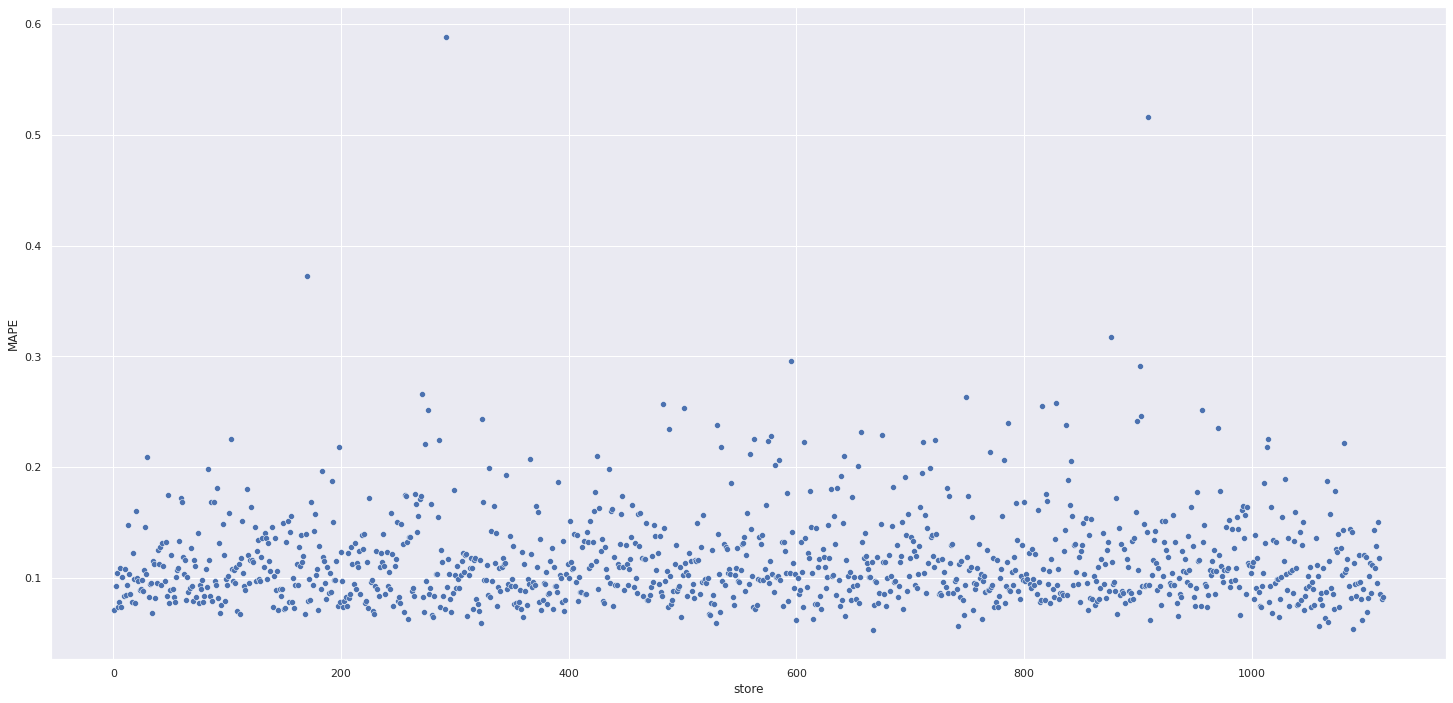

In [103]:
# analyzing the MAPE per store
sns.scatterplot( x='store' , y = 'MAPE', data = df92 );

## 9.2. Total Performance

In [104]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum( x ), axis = 0 ).reset_index().rename(columns = {'index':'Scenario', 0: 'Values' })

df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format) 

df93

,Scenario,Values
0,predictions,"R$287,260,416.00"
1,worst_scenario,"R$286,409,667.62"
2,best_scenario,"R$288,111,145.61"


## 9.3. Machine Learning Performance

In [105]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

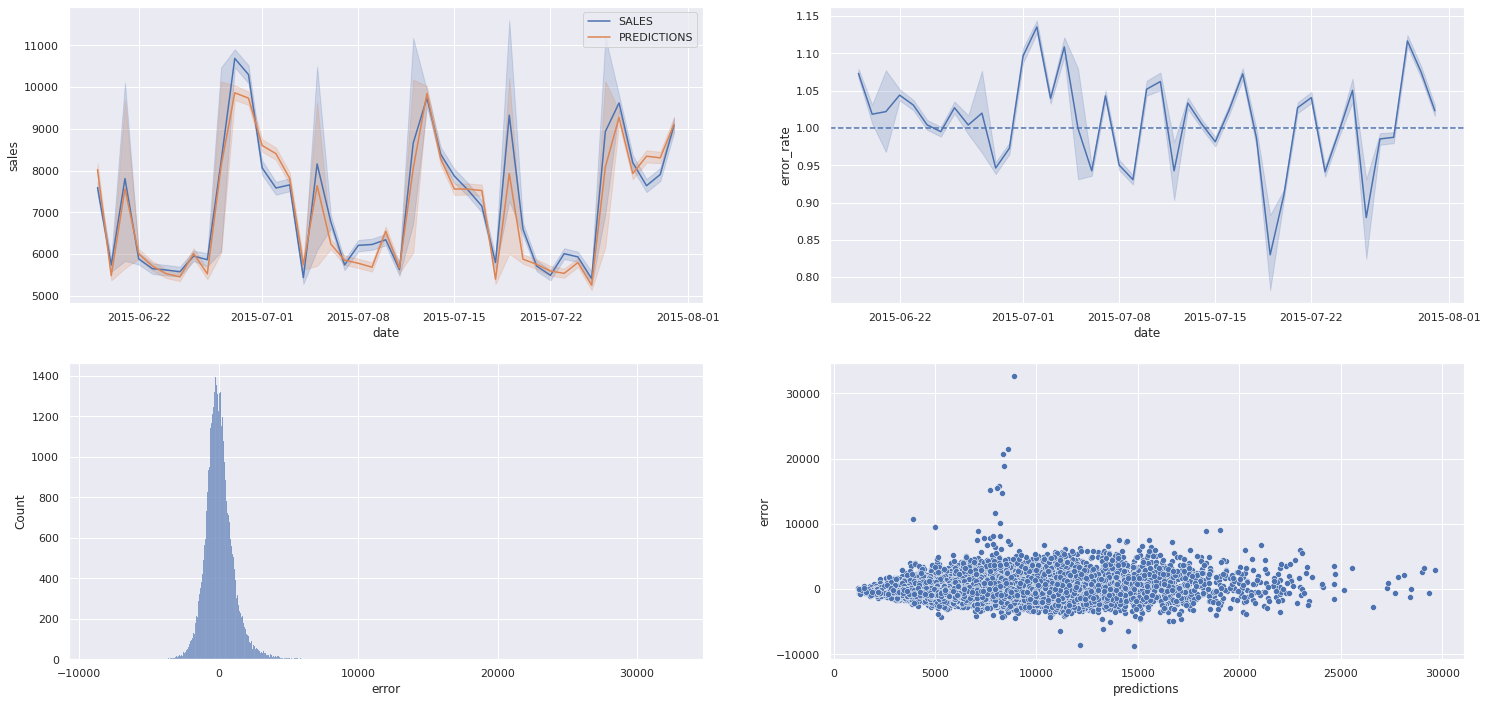

In [106]:
plt.subplot (2, 2, 1)
sns.lineplot( x='date', y='sales', data = df9, label = 'SALES' );
sns.lineplot( x='date', y='predictions', data = df9, label = 'PREDICTIONS' );

plt.subplot (2, 2, 2)
sns.lineplot( x='date', y='error_rate', data = df9);
plt.axhline(1, linestyle= "--")

plt.subplot (2, 2, 3)
sns.histplot( df9['error'] );

plt.subplot (2, 2, 4)
sns.scatterplot( df9['predictions'], df9['error'] );

# 10.0. DEPLOY MODEL TO PRODUCTION

In [107]:
trained_model = pickle.load(open('model/model_rossmann.pkl','rb'))
trained_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytee=0.7, colsample_bytree=1,
             eta=0.03, gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0299999993,
             max_delta_step=0, max_depth=5, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=3000, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

## 10.1. Rossman Class

In [108]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='/home/almir/repos/datascience_em_producao/'
        self.competition_distance_scaler   = pickle.load(open( self.home_path + 'parameter/competition_distance_scaler.pkl','rb'))
        self.competition_time_month_scaler = pickle.load(open( self.home_path + 'parameter/competition_time_month_scaler.pkl','rb'))
        self.promo_time_week_scaler        = pickle.load(open( self.home_path + 'parameter/promo_time_week_scaler.pkl','rb'))       
        self.year_scaler                   = pickle.load(open( self.home_path + 'parameter/year_scaler.pkl','rb'))
        self.store_type_scaler             = pickle.load(open( self.home_path + 'parameter/store_type_scaler.pkl','rb'))
        
    def data_cleaning(self, df1):
        
        ## Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list(map(snakecase, cols_old))

        # rename
        df1.columns = cols_new

        ## Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        ## Fillout NA
        df1['competition_distance'].max()

        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan ( x ) else x )

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1 )

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1 )

        # promo2_since_week        
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1)

        # promo2_since_year           
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1)

        # promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jun', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0,inplace = True)

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

        ## 1.6 Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    
    def feature_engineering( self, df2):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = int(df2['date'].dt.isocalendar().week)

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'] , month = x['competition_open_since_month'], day = 1 ), axis = 1)

        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/ 30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))

        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')


        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


        # 3.0. PASSO 03 - FILTRAGEM DAS VARIÁVEIS 

        ## 3.1. Filtragem das Linhas

        df2 = df2[df2['open'] != 0]

        ## 3.2. Seleção das Colunas

        cols_drop = ['open', 'promo_interval','month_map']
        df2 = df2.drop(cols_drop, axis = 1)
        
        return df2
    
    def data_preparation( self, df5):

            ## 5.2. Rescaling

            # competition_distance
            df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)

            # competition_time_month
            df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)

            # promo_time_week
            df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)

            # year
            df5['year'] = self.year_scaler.transform(df5[['year']].values)

            ### 5.3.1. Encoding
            # state_holiday - One Hot Encoding
            df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns = ['state_holiday'] )

            # store_type - Label Encoding
            df5['store_type'] = self.store_type_scaler.transform( df5['store_type'] )

            # assortment - Ordinal Encoding
            assortment_dict = {'basic':1, 'extra':2,'extended':3}
            df5['assortment'] = df5['assortment'].map(assortment_dict)

            ### 5.3.3. Nature Transformation
            # day_of_week
            df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7) ) )
            df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7) ) )

            # month
            df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12) ) )
            df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12) ) )

            # day
            df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30) ) )
            df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30) ) )

            # week_of_year
            df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52) ) )
            df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52) ) )

            cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                'competition_open_since_year', 'promo2','promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
                'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

            return df5[ cols_selected ]

    
    def get_prediction( self, model, original_data, test_data):
        # prediction
        pred = model.predict( test_data )

        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )

        return original_data.to_json( orient='records', date_format = 'iso' )

## 10.2. API Handler

In [109]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann # o pacote é a pasta onde está o script.py (pasta.nome do arquivo) importa a classe Rossmann

# loading model
model = pickle.load(open('/home/almir/repos/datascience_em_producao/model/model_rossmann.pkl','rb'))

# initialize API
app = Flask( __name__ ) 

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # multiple examples
            test_raw = pd.DataFrame( test_json, columns = test_json[0].keys() )
    
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation  
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 ) # modelo, dados originais e dado transformado que vai fazer a predição com o modelo
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [110]:
# loading test dataset
df10 = pd.read_csv('/home/almir/repos/datascience_em_producao/data/test.csv')

In [111]:
# merge test dataset + store
df_test = pd.merge(df10,df_store_raw, how='left',on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin( list(df10['Store'].sample(3)) ) ]

# removed closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)

In [112]:
# convert DataFrame to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [113]:
# API Call
# url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-model-app.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [114]:
# convert json to dataframe
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [115]:
# acumulate values per store
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range(len( d2 )):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
            d2.loc[i,'store'],
            d2.loc[i,'prediction']))

Store Number 566 will sell R$168,350.81 in the next 6 weeks
Store Number 618 will sell R$179,716.80 in the next 6 weeks
Store Number 720 will sell R$224,628.58 in the next 6 weeks
